#### **Hypothesis Generation**
Simply put, a hypothesis is a possible view or assertion of an analyst about the problem he or she is working upon. It may be true or may not be true.

**Demographics:**

1. Are employess from perticular dept are more likely to get promoted than other dept ?
2. Are employess from perticular region are prone to get promotion than other region ?
3. Are employees with Master's and above degree are very likely to get promoeted?
4. Are females less likely to get promoted than males?
5. Are referred employess getting promoted than other?
6. Are employees with high number(greater than 3) of trainings very likely to get promoted?
7. Are young employees less likely to get promoted?
8. Are middle age employees likely to get promoted?
9. Are old employees very likely to get promoted?
10. Employee who have previous year rating greater than average are prone to promotion?
11. Employee who have previous year rating less than average are less prone to promotion?
12. Are employees with average previous year rating are prone to promotion?
13. Are employee with low length of service are less prone to promotion?
14. Are employee with average length of service are prone to promotion?
15. Are employee with length of service greater than average are likely prone to promotion?
16. Are employee with KPI_met<80% less likely to get promoted than employee with KPI_met>80%?
17. Are employee with no award less likely to get promoted ?
18. Are employee with award likely to get promoted ?
19. are employee with high(> avg) avg training score are prone to promotion?
20. are employee with low(< avg) avg training score are less prone to promotion?
21. are employee with avg training score are prone to promotion?

In [ ]:
# importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn-whitegrid')

import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score

from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression

from lightgbm import LGBMClassifier

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

pd.set_option('display.max_colwidth', -1)

import warnings
warnings.simplefilter('ignore')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.


In [ ]:
from google.colab import files
upload = files.upload()

In [ ]:
TRAIN_PATH = '/content/train.csv'
TEST_PATH = '/content/test.csv'
SUBMISSION_PATH = '/content/sample_submission.csv'

In [ ]:
ss = pd.read_csv(SUBMISSION_PATH)
train = pd.read_csv(TRAIN_PATH)
test = pd.read_csv(TEST_PATH)

In [ ]:
data = train.copy()

In [ ]:
data.head()

,employee_id,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score,is_promoted
0,65438,Sales & Marketing,region_7,Master's & above,f,sourcing,1,35,5.0,8,1,0,49,0
1,65141,Operations,region_22,Bachelor's,m,other,1,30,5.0,4,0,0,60,0
2,7513,Sales & Marketing,region_19,Bachelor's,m,sourcing,1,34,3.0,7,0,0,50,0
3,2542,Sales & Marketing,region_23,Bachelor's,m,other,2,39,1.0,10,0,0,50,0
4,48945,Technology,region_26,Bachelor's,m,other,1,45,3.0,2,0,0,73,0


In [ ]:
ss.head()

Lets go and explore our training and test datasets. We will do the following steps:

1. Brief Look at the Dataset
2. See the dataset shape.
3. Target Distribution.
4. See the variables datatypes.
5. See the number of missing/null values.
6. See the number of unique values in each variable. 


#### **1. Brief look at the dataset**.

In [ ]:
train.head(3)

,employee_id,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score,is_promoted
0,65438,Sales & Marketing,region_7,Master's & above,f,sourcing,1,35,5.0,8,1,0,49,0
1,65141,Operations,region_22,Bachelor's,m,other,1,30,5.0,4,0,0,60,0
2,7513,Sales & Marketing,region_19,Bachelor's,m,sourcing,1,34,3.0,7,0,0,50,0


In [ ]:
test.head(3)

,employee_id,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score
0,8724,Technology,region_26,Bachelor's,m,sourcing,1,24,NaN,1,1,0,77
1,74430,HR,region_4,Bachelor's,f,other,1,31,3.0,5,0,0,51
2,72255,Sales & Marketing,region_13,Bachelor's,m,other,1,31,1.0,4,0,0,47


In [ ]:
ID_COL, TARGET_COL = 'employee_id', 'is_promoted'

#### **2. Dataset Shape (Number of Samples and Variables in dataset)**

In [ ]:
print(f'\nTrain contains {train.shape[0]} smaples and {train.shape[1]} variables.')
print(f'\nTest contains {test.shape[0]} smaples and {test.shape[1]} variables.')

features = [ c for c in train.columns if c not in [ID_COL, TARGET_COL]]
print(f'\nDataset contains {len(features)} features')


Train contains 54808 smaples and 14 variables.

Test contains 23490 smaples and 13 variables.

Dataset contains 12 features


#### **3. Target Distribution**

This is a binary classification problem. Lets have a look at the number of positive and negative examples that we have, or in our problem statement terms: '*Number of employee who did got promotion and the number of employee who did not'*

In [ ]:
train[TARGET_COL].value_counts(normalize=True)

0    0.91483
1    0.08517
Name: is_promoted, dtype: float64

Visually we are able to see communicate things more clearly and graphs help us do that. Lets visualize the same target distribution in a countplot.

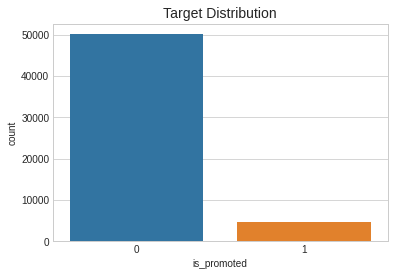

In [ ]:
_ = sns.countplot(train[TARGET_COL])
_ = plt.title('Target Distribution', fontsize=14)


Quite obviously dataset is very imbalanced. Only about 10 % of the examples are positive.

#### **4. Variable Datatypes**

Lets have a look at the kind of data types that is being used to store the variables in pandas.

pandas info() method on dataframe allows to do that. For each variable we can see the number of non-null values along with their datatypes.

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54808 entries, 0 to 54807
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   employee_id           54808 non-null  int64  
 1   department            54808 non-null  object 
 2   region                54808 non-null  object 
 3   education             52399 non-null  object 
 4   gender                54808 non-null  object 
 5   recruitment_channel   54808 non-null  object 
 6   no_of_trainings       54808 non-null  int64  
 7   age                   54808 non-null  int64  
 8   previous_year_rating  50684 non-null  float64
 9   length_of_service     54808 non-null  int64  
 10  KPIs_met >80%         54808 non-null  int64  
 11  awards_won?           54808 non-null  int64  
 12  avg_training_score    54808 non-null  int64  
 13  is_promoted           54808 non-null  int64  
dtypes: float64(1), int64(8), object(5)
memory usage: 5.9+ MB


Looks like we have a mixture of datatypes, a lot of these variables are object datatypes. Object datatypes are used to store strings along with other non-numeric data. This is obvious since we encountered a lot of strings when we had a look at the dataset.

Machine Learning Models understand only numbers so we will have to later convert these strings to numbers

#### **5. Null Values**

Although the info() function did tell us about non-null values ideally we want to have a look at the percentage of null values in each variable.

In [ ]:
null_values_pe_variable = 100 * (train.isnull().sum()/ train.shape[0]).round(3)
null_values_pe_variable.sort_values(ascending=False)

previous_year_rating    7.5
education               4.4
is_promoted             0.0
avg_training_score      0.0
awards_won?             0.0
KPIs_met >80%           0.0
length_of_service       0.0
age                     0.0
no_of_trainings         0.0
recruitment_channel     0.0
gender                  0.0
region                  0.0
department              0.0
employee_id             0.0
dtype: float64

#### **6. Unique values in each variable**

In [ ]:
train.nunique()

employee_id             54808
department              9    
region                  34   
education               3    
gender                  2    
recruitment_channel     3    
no_of_trainings         10   
age                     41   
previous_year_rating    5    
length_of_service       35   
KPIs_met >80%           2    
awards_won?             2    
avg_training_score      61   
is_promoted             2    
dtype: int64

The numerical features 'age', 'avg_training_score' contain a lot of unique values which is quite obvious.

Similarly 'region' contains 34 unique values for each of 34 places. Month from January to December contains '12' unique values.

### **Analyzing Each Variable & their relationships**

There are two types of features that we have:

1. Categorical
2. Numerical

Also our target is Binary

For each feature type we will be perform two types of analysis:

1. Univariate: Analyze 1 feature at a time

2. Bivariate: Analyze the relationship of that feature with target variable, i.e. 'is_promoted'


But before jumping straight into analysis, lets have a look at the variables we had and try to ask some questions ourselves



In [ ]:
train.columns

Index(['employee_id', 'department', 'region', 'education', 'gender',
       'recruitment_channel', 'no_of_trainings', 'age', 'previous_year_rating',
       'length_of_service', 'KPIs_met >80%', 'awards_won?',
       'avg_training_score', 'is_promoted'],
      dtype='object')

### Segregating Categorical & Numerical Variables

In [ ]:
cat_cols = ['department', 
            'region', 
            'education', 
            'gender', 
            'recruitment_channel', 
            'KPIs_met >80%', 
            'awards_won?', ]

In [ ]:
num_cols = [c for c in features if c not in cat_cols]

#### **Categorical Features**

#### **Univariate Analysis - Pie Charts.**

Pie Charts can be useful in seeing the proportion of samples, that fall into each category of a categorical variable. For each of the categorical variables we will make a pie chart.

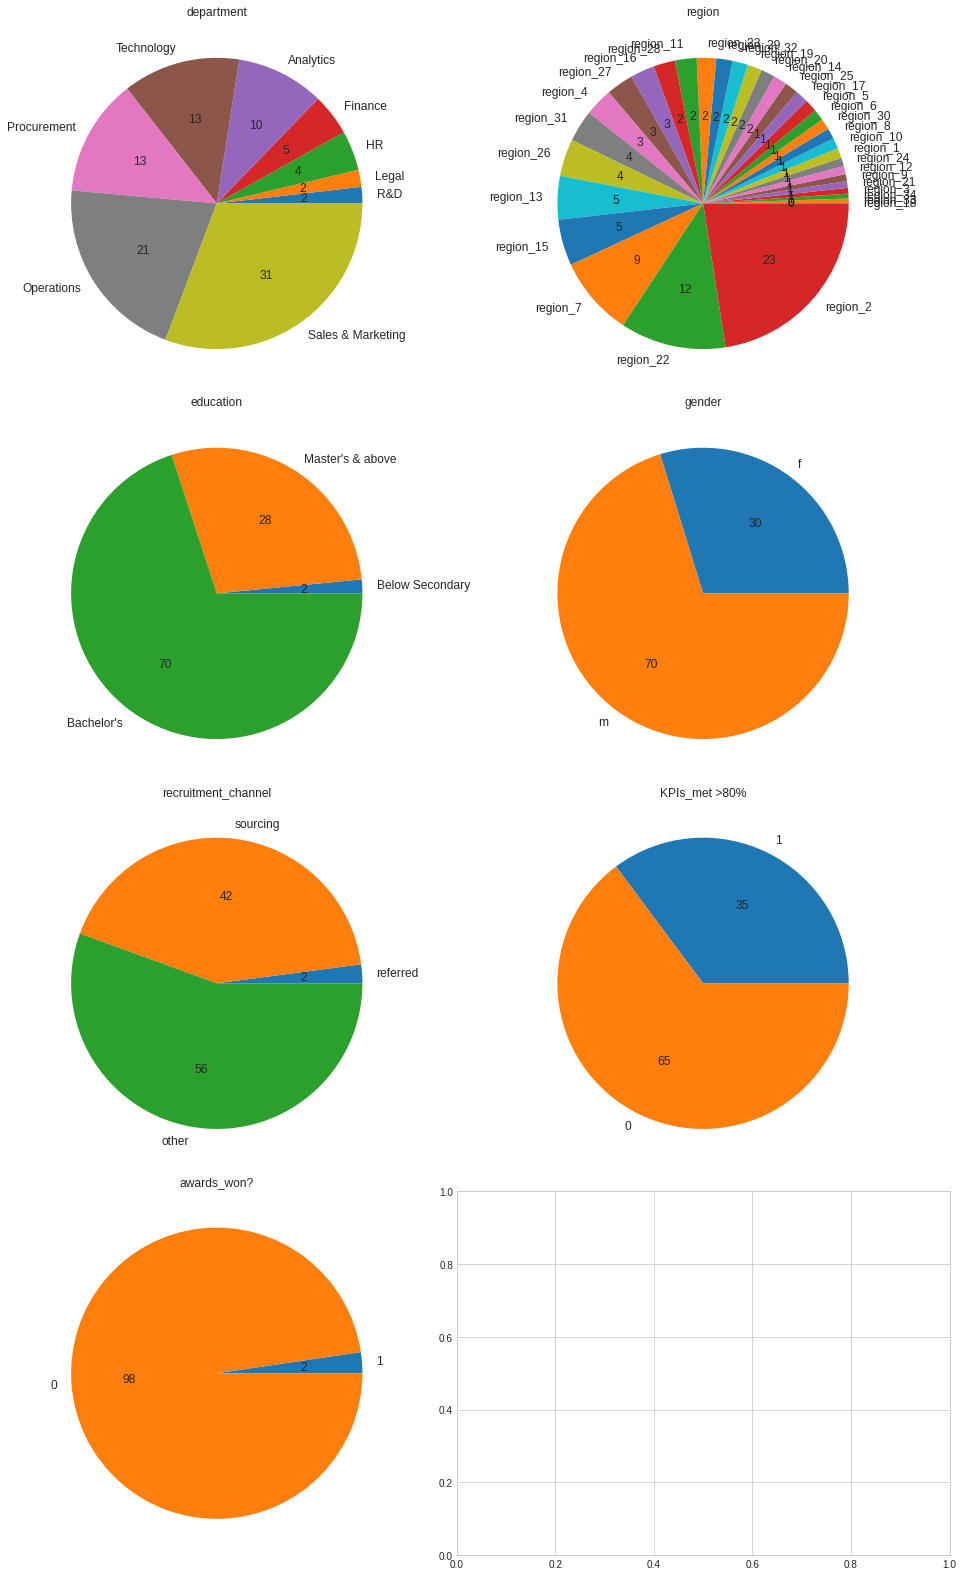

In [ ]:
fig, axes = plt.subplots(4, 2, figsize=(14, 22))
axes = [ax for axes_row in axes for ax in axes_row]

for i, c in enumerate(train[cat_cols]):
    _ = train[c].value_counts()[::-1].plot(kind = 'pie', ax=axes[i], title=c, autopct='%.0f', fontsize=12)
    _ = axes[i].set_ylabel('')
    
_ = plt.tight_layout()

#### **Univariate Analysis - CountPlots**

Another way of looking at the counts of each of the categories is countplots. These are similar to barplots with the width of the bars representing the count of the category in the variable

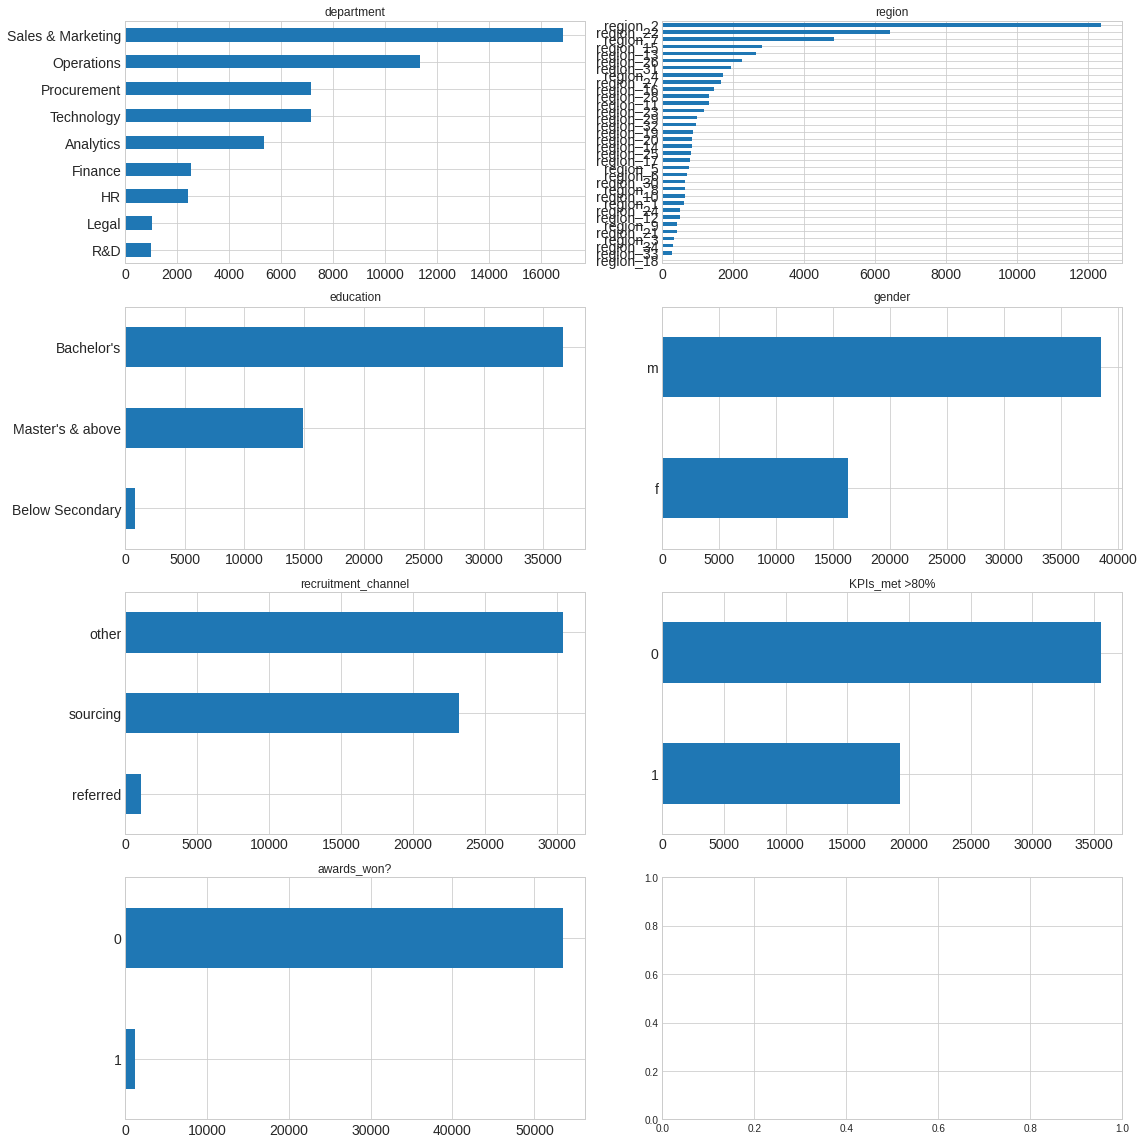

In [ ]:
fig, axes = plt.subplots(4, 2, figsize=(16, 16))
axes = [ax for axes_row in axes for ax in axes_row]

for i, c in enumerate(train[cat_cols]):
    _ = train[c].value_counts()[::-1].plot(kind = 'barh', ax=axes[i], title=c, fontsize=14)
    
_ = plt.tight_layout()

##### **Bivariate Analysis Relationships with Target**

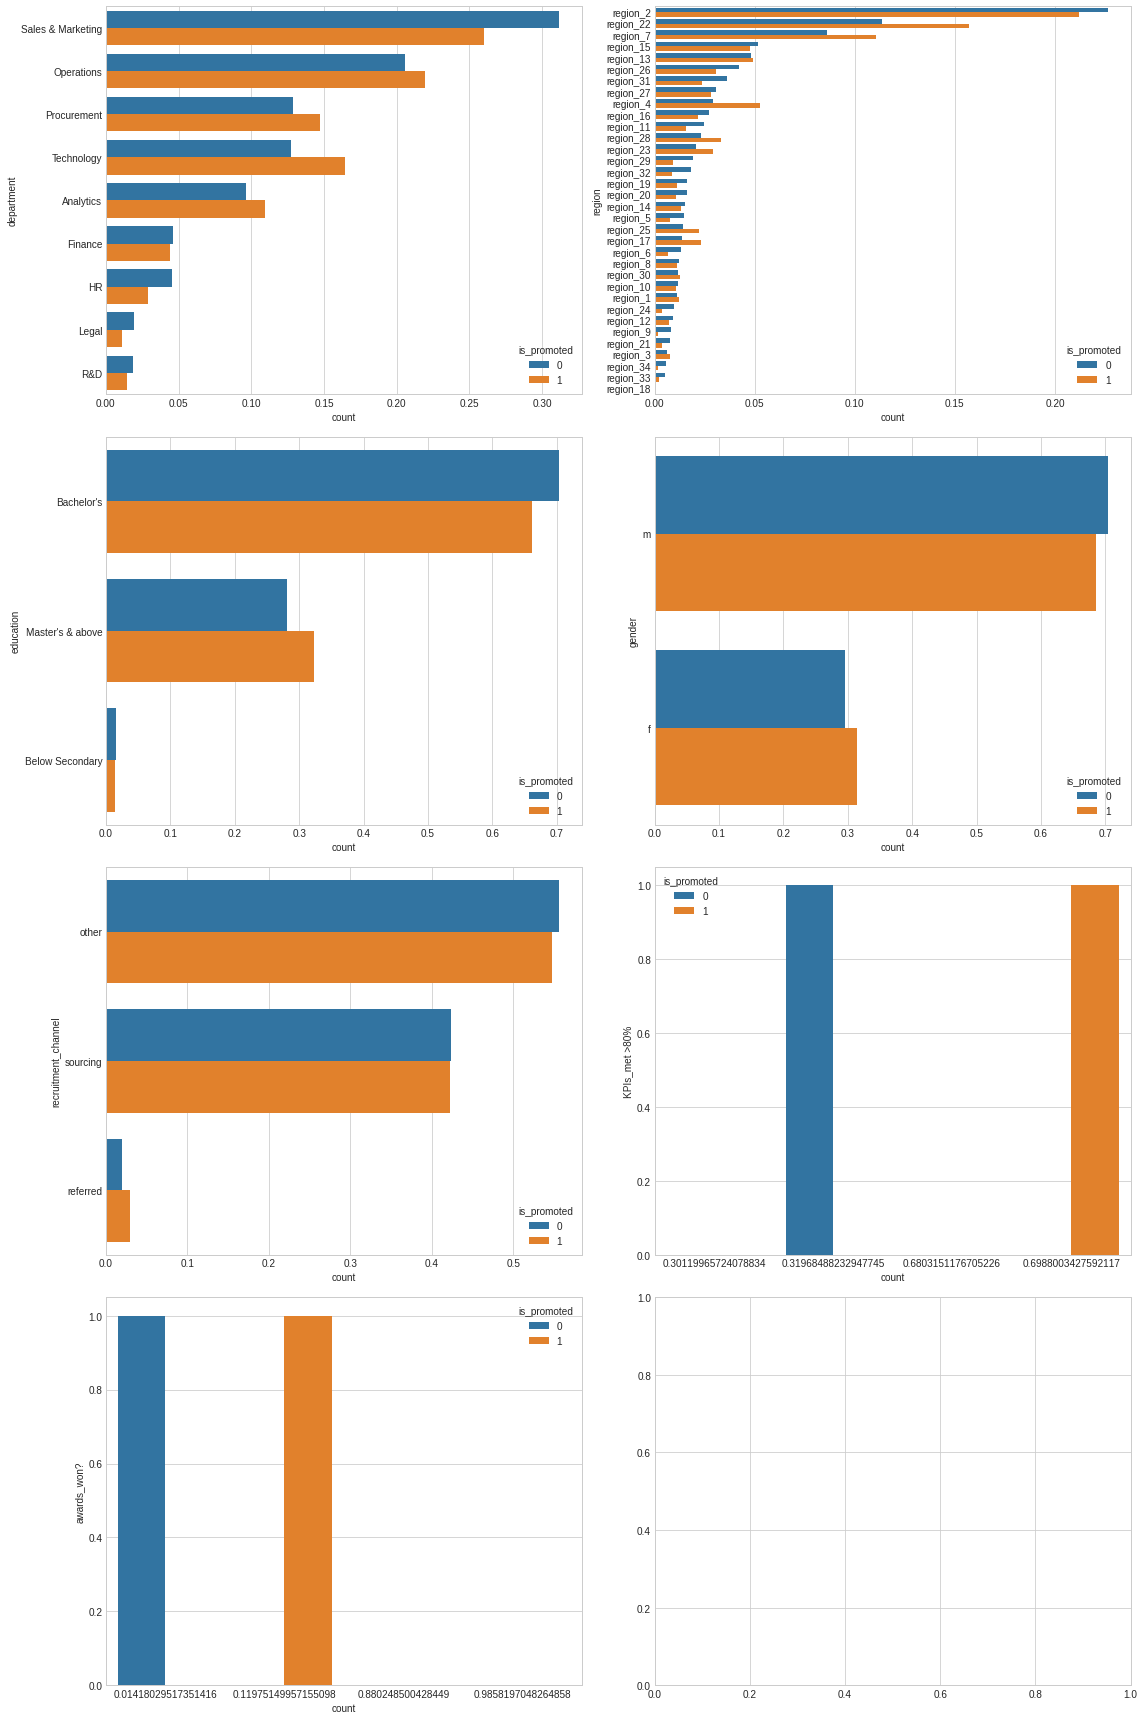

In [ ]:

fig, axes = plt.subplots(4, 2, figsize=(16, 24))
axes = [ax for axes_row in axes for ax in axes_row]

for i, c in enumerate(train[cat_cols]):
    fltr = train[TARGET_COL] == 0
    vc_a = train[fltr][c].value_counts(normalize=True).reset_index().rename({'index' : c, c: 'count'}, axis=1)

    vc_b = train[~fltr][c].value_counts(normalize=True).reset_index().rename({'index' : c, c: 'count'}, axis=1)

    vc_a[TARGET_COL] = 0
    vc_b[TARGET_COL] = 1

    df = pd.concat([vc_a, vc_b]).reset_index(drop = True)

    _ = sns.barplot(y = c, x = 'count', data =df , hue=TARGET_COL, ax=axes[i])
    
_ = plt.tight_layout()

#### **Numerical Features**

##### 1. **Univariate Analysis - Boxplots**

Boxplot can be used to see the spread of the numerical variables, and identify outliers

https://en.wikipedia.org/wiki/Box_plot


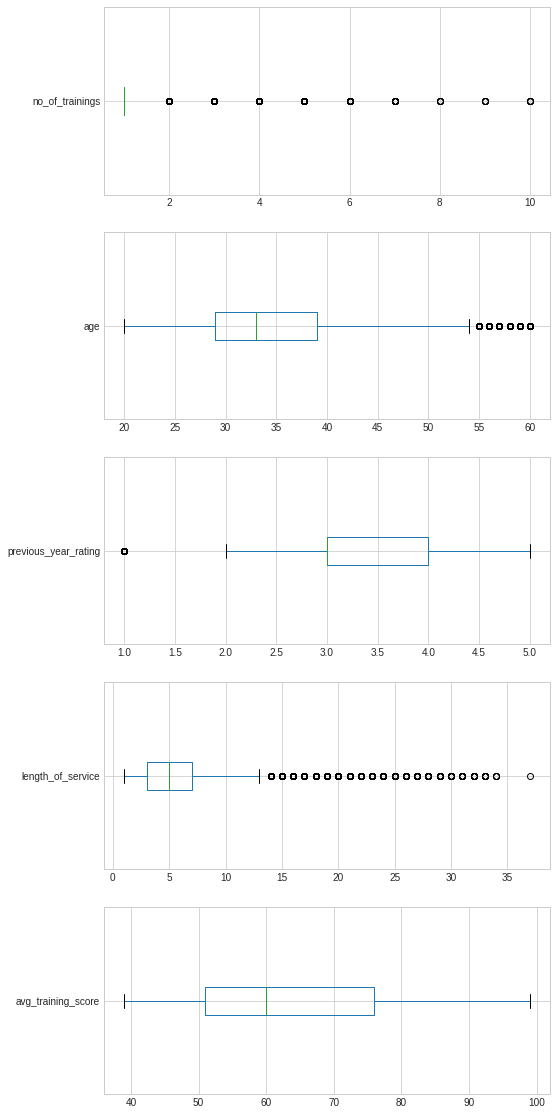

In [ ]:
fig, axes = plt.subplots(5, 1, figsize=(8, 20))
for i, c in enumerate(num_cols):
  _ = train[[c]].boxplot(ax=axes[i], vert=False)

##### **2. Univariate Analysis - Density Plots**

A kernel density estimate (KDE) plot is a method for visualizing the distribution of observations in a dataset, analagous to a histogram. KDE represents the data using a continuous probability density curve in one or more dimensions.

https://seaborn.pydata.org/generated/seaborn.kdeplot.html

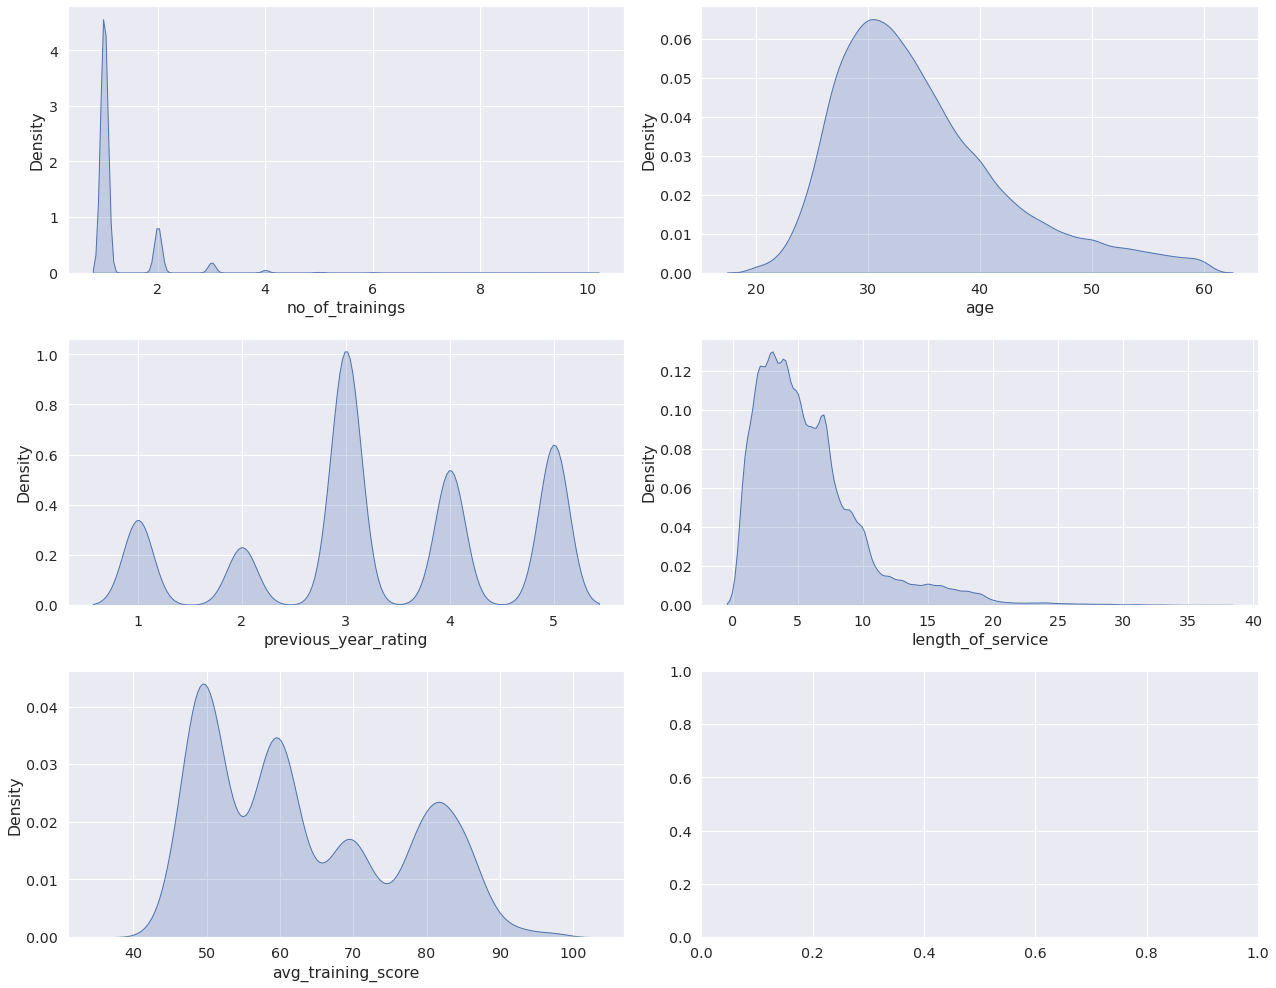

In [ ]:
sns.set(font_scale=1.3)
fig, axes = plt.subplots(3, 2, figsize=(18, 14))
axes = [ax for axes_row in axes for ax in axes_row]
for i, c in enumerate(num_cols):
  plot = sns.kdeplot(data=train, x=c, ax=axes[i], fill=True)
plt.tight_layout()

##### **3. Bivariate Analysis KDE plots - Relationships with Target Variable**.

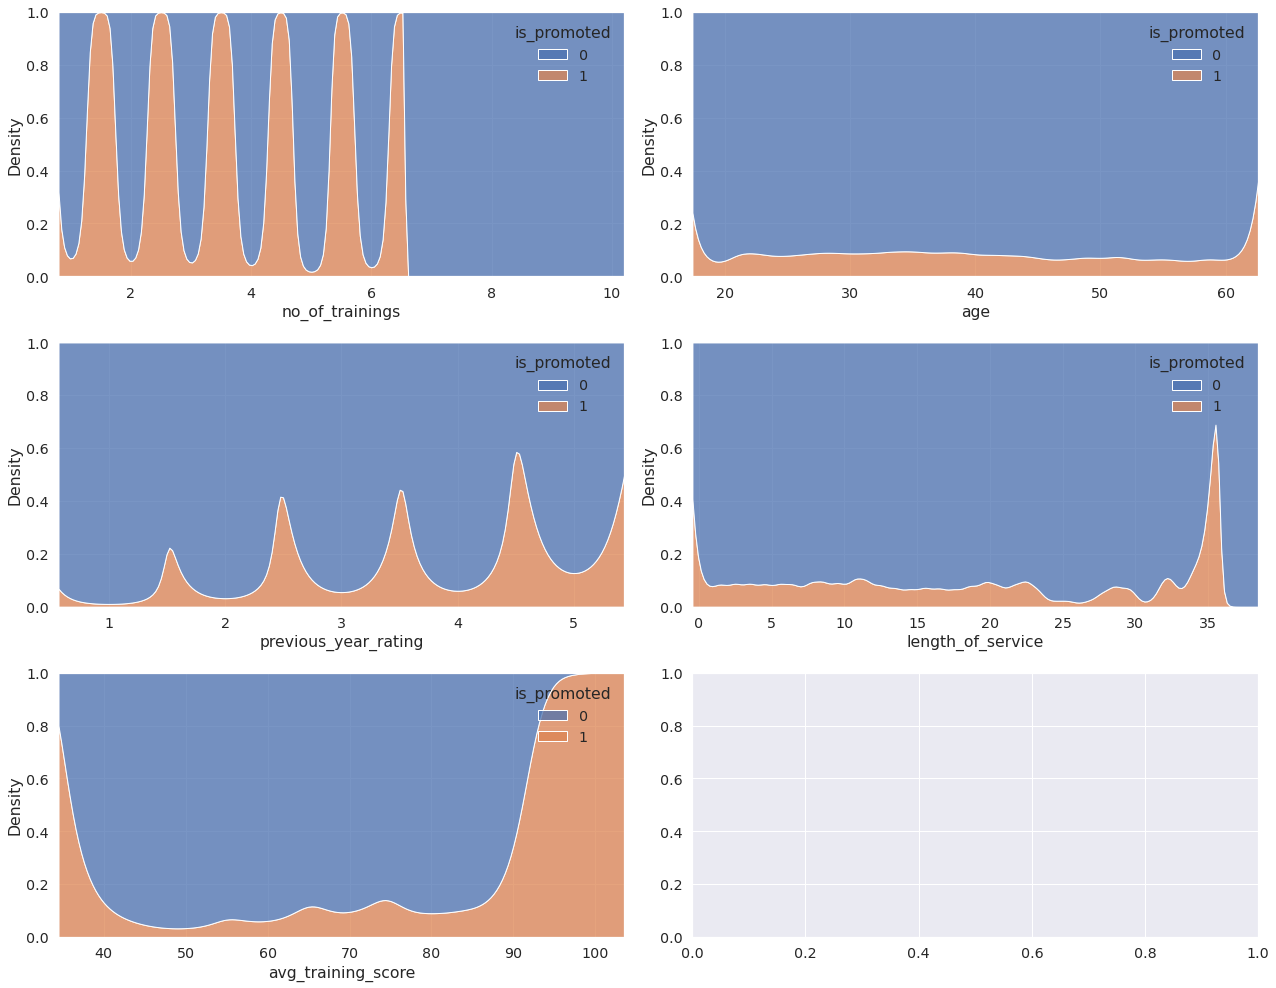

In [ ]:
sns.set(font_scale=1.3)
fig, axes = plt.subplots(3, 2, figsize=(18, 14))
axes = [ax for axes_row in axes for ax in axes_row]
for i, c in enumerate(num_cols):
  plot = sns.kdeplot(data=train, x=c, hue=TARGET_COL, multiple='fill', ax=axes[i])
plt.tight_layout()

##### **4. Bivariate Analysis - Horizontal BarPlots**

For each numerical Variable. We will plot the median of the numerical variable for:


1. When is_not_promoted == 0
2. when is_promoted == 1

**We are choosing median since median is not affected by outliers**, and our data has a lot of outlers

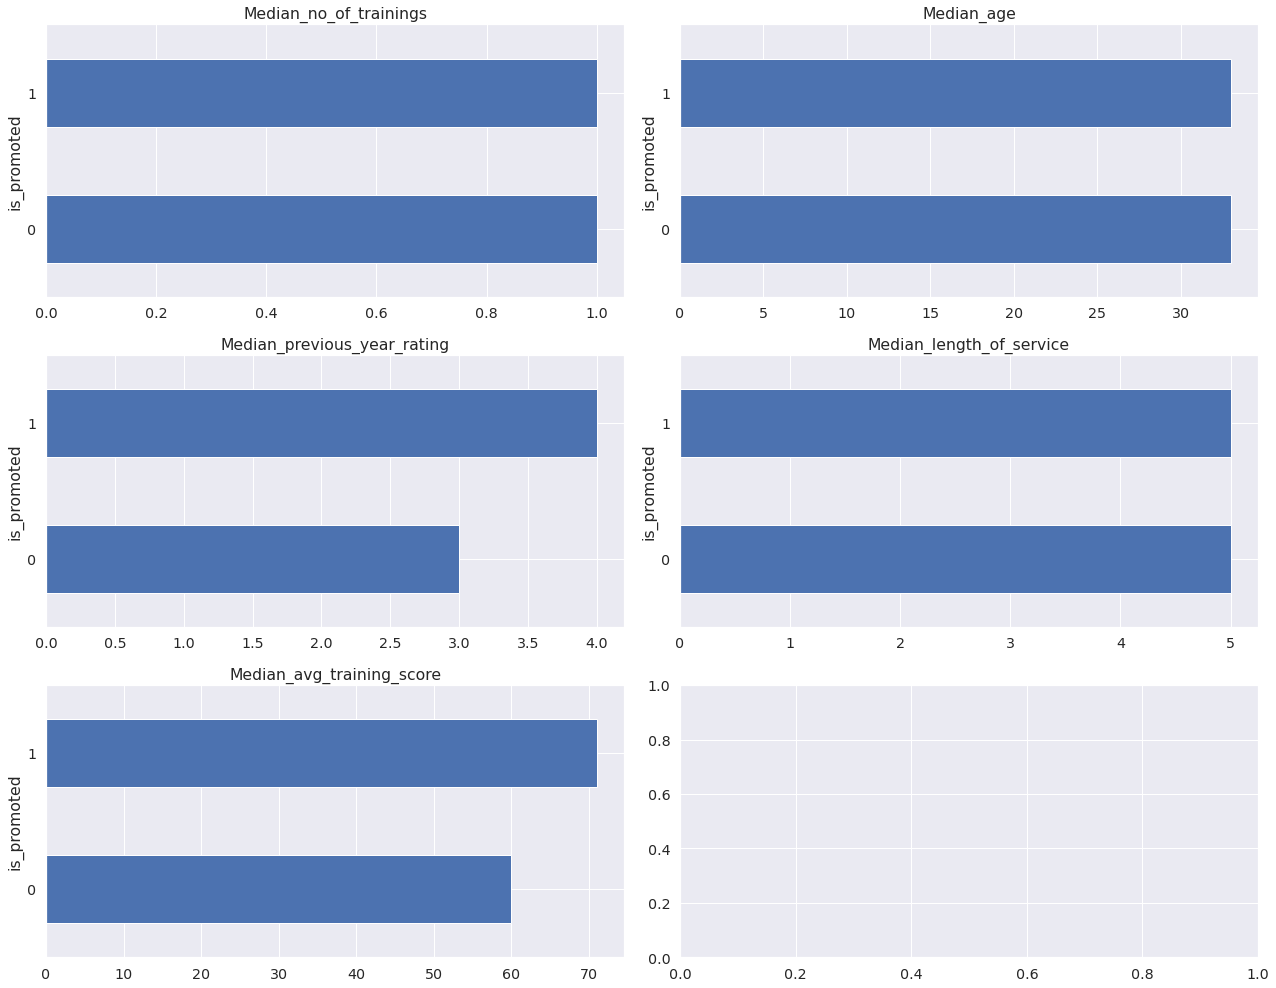

In [ ]:
sns.set(font_scale=1.3)
fig, axes = plt.subplots(3, 2, figsize=(18, 14))
axes = [ax for axes_row in axes for ax in axes_row]
for i, c in enumerate(num_cols):
  plot = train.groupby(TARGET_COL)[c].median().plot(kind = 'barh', title=f'Median_{c}', ax=axes[i])
plt.tight_layout()

**Q. Do employee with a higher avg training score more likely to get promoted than people with low avg training score ?**

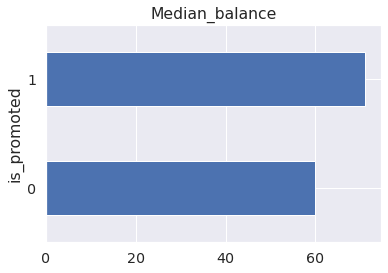

In [ ]:
_ = train.groupby(TARGET_COL)['avg_training_score'].median().plot(kind = 'barh', title=f'Median_balance')

If you see the plot above median avg training scores of employees to no promotion is around 60 whereas median avg training score of employees to promotion is 75. This definitely supports our initial hypothesis. So yes our hypothesis seems true.

**Q. Do employee with a higher previous year rating more likely to get promoted than people with low previous year rating ?**

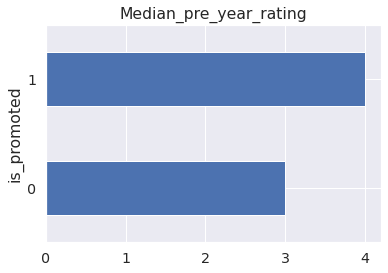

In [ ]:
_ = train.groupby(TARGET_COL)['previous_year_rating'].median().plot(kind = 'barh', title=f'Median_pre_year_rating')

If you see the plot above median previous year rating of employees to no promotion is around 3 whereas median previous year rating of employees to promotion is 4. This definitely supports our initial hypothesis. So yes our hypothesis seems true.

**Q. Are younger employees more likely to get promoted as compared to old employees?**

It's not very clear from our above plot since we have median age of around 33 for both cases

Lets dig deeper.

We will define:
 old as Age > 50
 Not Old as Age <= 50

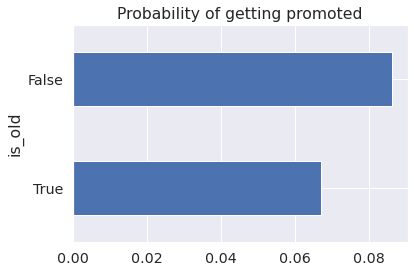

In [ ]:
train['is_old'] = True
train.loc[train['age'] <= 50, 'is_old'] = False

_ = train.groupby('is_old')[TARGET_COL].mean().sort_values().plot(kind = 'barh', title='Probability of getting promoted')

Looks like younger age employees are definitely more likely to get promoted compared to old age employees

**Q. Are younger employees(junior) more likely to get promoted compared to old employees(senior) ? (based on length of service)**

It's not very clear from our above plot since we have median age of around 5 for both cases

Lets dig deeper.

We will define:
 senior as length_of_service > 4
 Not senior as length_of_service <= 4

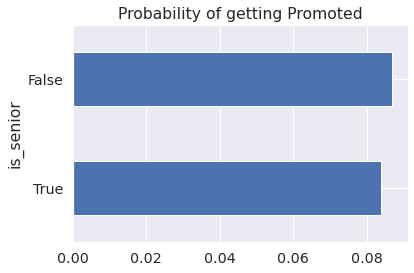

In [ ]:
train['is_senior'] = True
train.loc[train['length_of_service'] <= 4, 'is_senior'] = False

_ = train.groupby('is_senior')[TARGET_COL].mean().sort_values().plot(kind = 'barh', title='Probability of getting Promoted')

Looks like junior employees are just slightly to get promoted compared to senior employees

##### **5. Bivariate Analysis - Correlation Heatmaps**

<Figure size 1008x576 with 0 Axes>

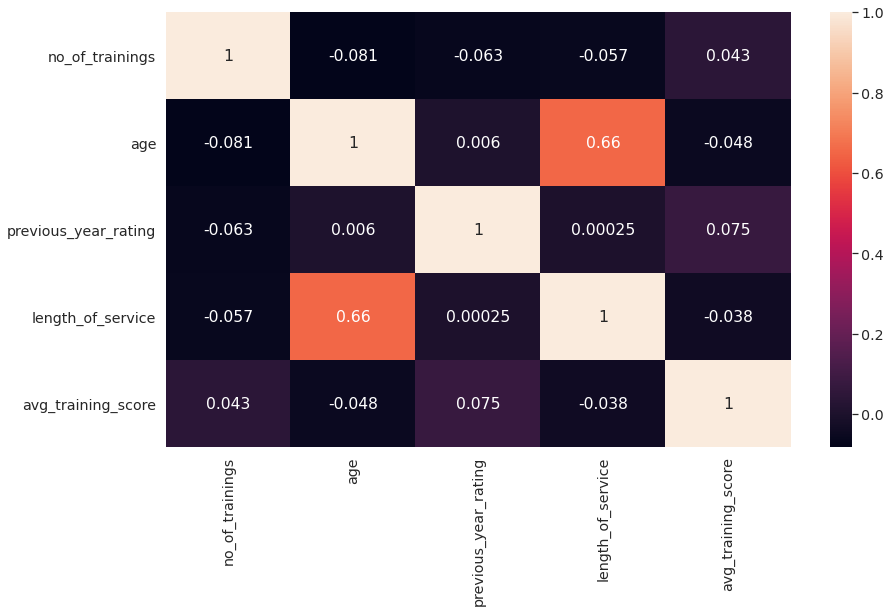

In [ ]:
plt.figure(figsize=(14, 8))
_ = sns.heatmap(train[num_cols].corr(), annot=True)

**Exercise**

What are the more interesting things you can find from this correlation plot ? 

1. EDA has a structure but it is also an art
2. Its not about how beautiful the plots are
3. EDA is the backbone of any ML project for structured data

**Next steps for EDA: Ideas and Suggestions.**

This was a basic EDA, to demonstrate its purpose. However the data contains a lot more hidden information. EDA has no end, and as we dig deeper into the data, we are sure to find more meaningful and interesting insights.

1. **Do a multivariate Feature Analysis**. Here we only have taken a look at each of the features and its relationship with the target variable, or relationship betwen two features. But can two or more features together influence the target more ?

2. **Dig deeper into more important features**. This can be done with the help of Feature Importance Scores. In the next section we will see how to create a baseline model and get feature importances.

# Metric and Baseline Model

**F1 Score**


In statistical analysis of binary classification, the F1 score (also F-score or F-measure) is a measure of a test's accuracy. It is calculated from the precision and recall of the test, where the precision is the number of correctly identified positive results divided by the number of all positive results, including those not identified correctly, and the recall is the number of correctly identified positive results divided by the number of all samples that should have been identified as positive.

The F1 score is the harmonic mean of the precision and recall. The highest possible value of F1 is 1, indicating perfect precision and recall, and the lowest possible value is 0, if either the precision or the recall is zero. 

https://en.wikipedia.org/wiki/F1_score

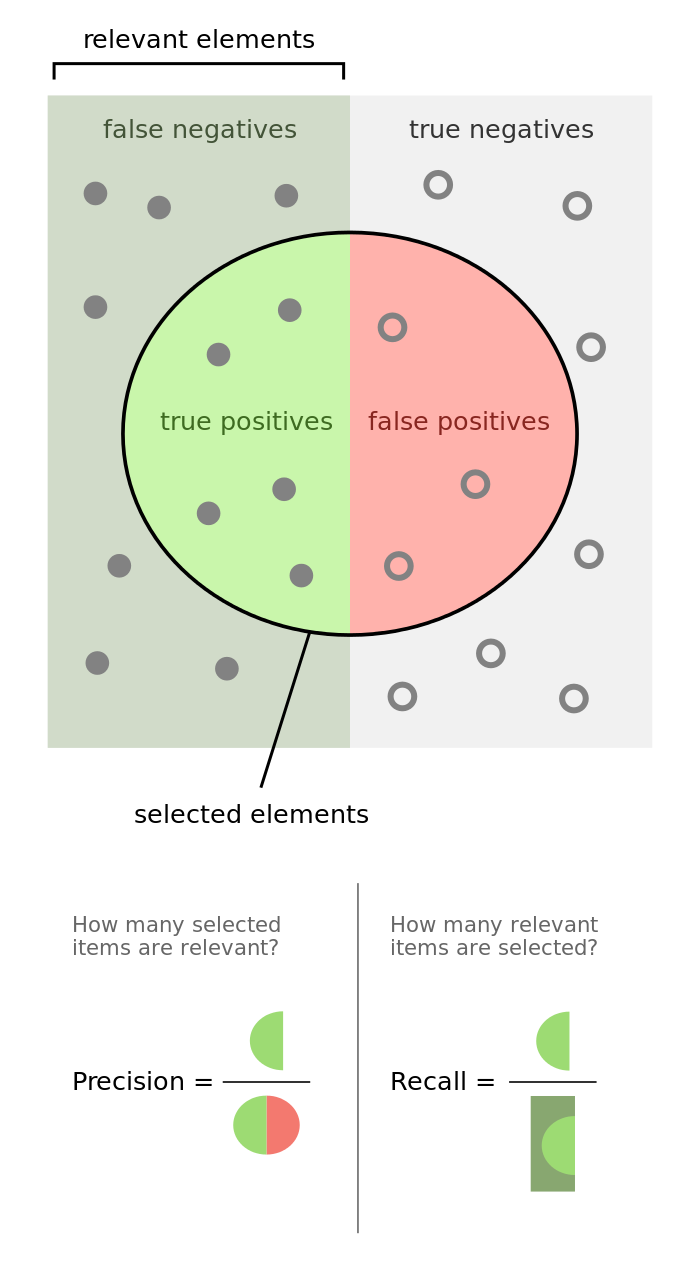


Knowing about different kinds of metrics and their usecases is very important to handle different kinds of problems. Its highly recommended to go through this course which tells about different kinds of evaluation metrics.

**Evaluation Metrics for Machine Learning Models**

https://bit.ly/34DZ1wR

## **Baseline Models**

**Helper Function to Download Test Predictions as CSV**

In [ ]:
ss.head()

,employee_id,is_promoted
0,8724,0
1,74430,0
2,72255,0
3,38562,0
4,64486,0


In [ ]:
def download_preds(preds_test, file_name = 'HR_Analytics_sub.csv'):

  ## 1. Setting the target column with our obtained predictions
  ss[TARGET_COL] = preds_test

  ## 2. Saving our predictions to a csv file

  ss.to_csv(file_name, index = False)

  ## 3. Downloading and submitting the csv file
  from google.colab import files
  files.download(file_name)

### **Model A. (Predicting all instances as majority)**

In [ ]:
target = train[TARGET_COL]
target.value_counts()

0    50140
1    4668 
Name: is_promoted, dtype: int64

As we saw before too, 0 is the majority class. Lets begin by predicting everything as 0.

In [ ]:
preds_target = np.zeros(len(train))

accuracy = accuracy_score(target, preds_target)
f1 = f1_score(target, preds_target)

print(f'Accuracy score is: {accuracy}')
print(f'F1 score is: {f1}')

Accuracy score is: 0.9148299518318493
F1 score is: 0.0


In [ ]:
preds_test = np.zeros(len(test), dtype=int)

In [ ]:
download_preds(preds_test, file_name = 'HR_Aanalytics_zero_sub.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Had the metric been accuracy, we would have got an accuracy of almost 91 %, but F1-score is forcing us to create a better model.
There's no point submitting a model with train score of 0 to the leaderboard, but you are welcome to try

### **Model B. (Random Predictions with equal probability)**

In [ ]:
#### Since we are dealing with randomness, its important to set a seed, so we get same randomness everytime.
np.random.seed(2)

preds_target = np.random.choice([0, 1], size=len(train))


f1_score(target, preds_target)

0.14561924098079024

Not an excellent score. Nevertheless it is much better than getting 0. Lets submit this on the leaderboard.

In [ ]:
np.random.seed(2)
preds_test = np.random.choice([0, 1], size=len(test))
download_preds(preds_test, file_name = 'HR_Analytics_random_sub.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

This scores 0.1400 on the leaderboard, quite similar to our train score.

###  **Rule Based: Classifying using Most Important Feature(s)**

We saw that balance and last_contact_duration could tell us a lot about the target.

Just to recap here were the plots that we got.

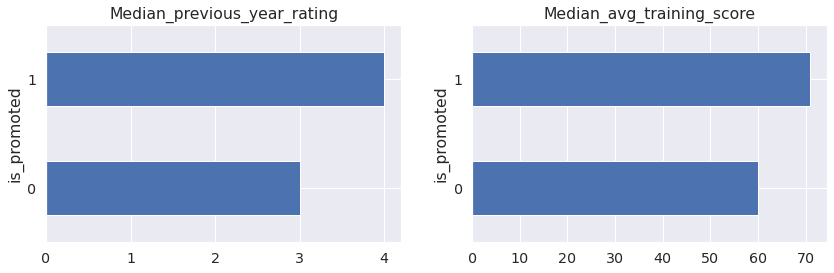

In [ ]:
sns.set(font_scale=1.3)
fig, axes = plt.subplots(1, 2, figsize=(14, 4))
for i, c in enumerate(['previous_year_rating', 'avg_training_score']):
  plot = train.groupby(TARGET_COL)[c].median().plot(kind = 'barh', title=f'Median_{c}', ax=axes[i])

We had observe that employees not getting promoted have a median_previous_year_rating of approx 3 and median_avg_training_score of around 60

So initially we can classify all samples with previous_year_rating < 3, and median_avg_training_score < 60 as 0 or 'is_not_promoted'



In [ ]:
def rule_based_clf(df):
  preds = np.ones(len(df), dtype=int)
  rule = (df['previous_year_rating'] < 3) | (df['avg_training_score'] < 60)
  preds[rule] = 0
  return preds

In [ ]:
preds_train = rule_based_clf(train)
f1_score(target, preds_train)

0.22344372681049884

In [ ]:
preds_test = rule_based_clf(test)
download_preds(preds_test, file_name='HR_Analytics_rule_based_2.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

This scores **0.21619** on the leaderboard. Again very close to our train score.

**Exercise**

* Try changing the thresholds from 60 and 40 to something else, how does the training score vary ? How does the test score vary ?
* Try analyzing the data to create more such rules to classify the examples.

In [ ]:
!pip install -q catboost
!pip install -q --upgrade seaborn

     |████████████████████████████████| 65.7MB 59kB/s 


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn-whitegrid')

import seaborn as sms
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.linear_model import LogisticRegression

from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

pd.set_option('display.max_colwidth', -1)

import warnings
warnings.simplefilter('ignore')

In [ ]:
def download_preds(preds_test, file_name= 'HR_Analytics_sub.csv'):

  ## 1. Setting the TARGET column with our obtained predictions
  ss[TARGET_COL] = preds_test.astype(int) 

  ## 2. Saving our predictions to csv file
  ss.to_csv(file_name, index=False)

  ## 3. Downloading and submitting the cav file
  from google.colab import files
  files.download(file_name)

### **C. Classification Models.**


There are a lot of classification models that can be used, many of them such as Gradient Boosting Models and Neural Networks are be used to win competitions. However, for the purpose of creating a baseline classification model, we will make the following:

1. Logistic Regression.
2. Decision Tree

In [ ]:
train.head()

,employee_id,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score,is_promoted
0,65438,Sales & Marketing,region_7,Master's & above,f,sourcing,1,35,5.0,8,1,0,49,0
1,65141,Operations,region_22,Bachelor's,m,other,1,30,5.0,4,0,0,60,0
2,7513,Sales & Marketing,region_19,Bachelor's,m,sourcing,1,34,3.0,7,0,0,50,0
3,2542,Sales & Marketing,region_23,Bachelor's,m,other,2,39,1.0,10,0,0,50,0
4,48945,Technology,region_26,Bachelor's,m,other,1,45,3.0,2,0,0,73,0


In [ ]:
?pd.get_dummies

In [ ]:
pd.get_dummies(train[['department']])

,department_Analytics,department_Finance,department_HR,department_Legal,department_Operations,department_Procurement,department_R&D,department_Sales & Marketing,department_Technology
0,0,0,0,0,0,0,0,1,0
1,0,0,0,0,1,0,0,0,0
2,0,0,0,0,0,0,0,1,0
3,0,0,0,0,0,0,0,1,0
4,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...
54803,0,0,0,0,0,0,0,0,1
54804,0,0,0,0,1,0,0,0,0
54805,1,0,0,0,0,0,0,0,0
54806,0,0,0,0,0,0,0,1,0


**Steps to Make a Baseline Classification Model**

1. Concatenate/Join the train and test Datasets. All kinds of processing must be performed on both train and test datasets together.

2. Convert all Categorical Variables to numbers. We will be use OneHot Encoding for this. 

3. Fill Null Values. This can be followed by other data processing and feature engineering steps, but we will go into it later.

4. Split the dataset back into train and test datasets.

5. Split the train set into train and validation sets.

6. Fit a classification Model on train, check its results on validation set.

7. Predict for the test set.

8.  Save the submission as a csv file and submit the model on AV.

Lets complete each of these steps one by one.

**1. Concating/Joining train and test datasets.**


In [ ]:
train.shape, test.shape

((54808, 14), (23490, 13))

In [ ]:
54808+23490

78298

In [ ]:
df = pd.concat([train, test], axis=0).reset_index(drop = True)
df.shape

(78298, 14)

In [ ]:
df

,employee_id,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score,is_promoted
0,65438,Sales & Marketing,region_7,Master's & above,f,sourcing,1,35,5.0,8,1,0,49,0.0
1,65141,Operations,region_22,Bachelor's,m,other,1,30,5.0,4,0,0,60,0.0
2,7513,Sales & Marketing,region_19,Bachelor's,m,sourcing,1,34,3.0,7,0,0,50,0.0
3,2542,Sales & Marketing,region_23,Bachelor's,m,other,2,39,1.0,10,0,0,50,0.0
4,48945,Technology,region_26,Bachelor's,m,other,1,45,3.0,2,0,0,73,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
78293,53478,Legal,region_2,Below Secondary,m,sourcing,1,24,3.0,1,0,0,61,NaN
78294,25600,Technology,region_25,Bachelor's,m,sourcing,1,31,3.0,7,0,0,74,NaN
78295,45409,HR,region_16,Bachelor's,f,sourcing,1,26,4.0,4,0,0,50,NaN
78296,1186,Procurement,region_31,Bachelor's,m,sourcing,3,27,NaN,1,0,0,70,NaN


**2. Encoding categorical columns.**

There are multiple ways to encoded categorical variables. For the sake of simplicity, we will be using One-Hot Encoding.

In [ ]:
df = pd.get_dummies(df, columns = cat_cols)

In [ ]:
df.head()

,employee_id,education,no_of_trainings,age,previous_year_rating,length_of_service,avg_training_score,is_promoted,department_Analytics,department_Finance,department_HR,department_Legal,department_Operations,department_Procurement,department_R&D,department_Sales & Marketing,department_Technology,region_region_1,region_region_10,region_region_11,region_region_12,region_region_13,region_region_14,region_region_15,region_region_16,region_region_17,region_region_18,region_region_19,region_region_2,region_region_20,region_region_21,region_region_22,region_region_23,region_region_24,region_region_25,region_region_26,region_region_27,region_region_28,region_region_29,region_region_3,region_region_30,region_region_31,region_region_32,region_region_33,region_region_34,region_region_4,region_region_5,region_region_6,region_region_7,region_region_8,region_region_9,gender_f,gender_m,recruitment_channel_other,recruitment_channel_referred,recruitment_channel_sourcing,KPIs_met >80%_0,KPIs_met >80%_1,awards_won?_0,awards_won?_1
0,65438,Master's & above,1,35,5.0,8,49,0.0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,1,1,0
1,65141,Bachelor's,1,30,5.0,4,60,0.0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,0,1,0
2,7513,Bachelor's,1,34,3.0,7,50,0.0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1,0,1,0
3,2542,Bachelor's,2,39,1.0,10,50,0.0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,0,1,0
4,48945,Bachelor's,1,45,3.0,2,73,0.0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,0,1,0


In [ ]:
df.shape

(78298, 60)

**3. Filling Null Values**

As seen earlier in our EDA, our dataset contains null values. There could be multiple ways to fill our Null Values, but for now we will fill it with a large negative random number say -999

In [ ]:
mode = df['education'].mode()[0]
mode

"Bachelor's"

In [ ]:
mean = df.loc[:len(train.index),'previous_year_rating'].mean()
mean

3.329255780917055

In [ ]:
df['education'] = df['education'].fillna(-999)
df['previous_year_rating'] = df['previous_year_rating'].fillna(-999)

df.isnull().sum().sum()

23490

In [ ]:
df = pd.get_dummies(df, columns = ['education'])

In [ ]:
df.head()

,employee_id,no_of_trainings,age,previous_year_rating,length_of_service,avg_training_score,is_promoted,department_Analytics,department_Finance,department_HR,department_Legal,department_Operations,department_Procurement,department_R&D,department_Sales & Marketing,department_Technology,region_region_1,region_region_10,region_region_11,region_region_12,region_region_13,region_region_14,region_region_15,region_region_16,region_region_17,region_region_18,region_region_19,region_region_2,region_region_20,region_region_21,region_region_22,region_region_23,region_region_24,region_region_25,region_region_26,region_region_27,region_region_28,region_region_29,region_region_3,region_region_30,region_region_31,region_region_32,region_region_33,region_region_34,region_region_4,region_region_5,region_region_6,region_region_7,region_region_8,region_region_9,gender_f,gender_m,recruitment_channel_other,recruitment_channel_referred,recruitment_channel_sourcing,KPIs_met >80%_0,KPIs_met >80%_1,awards_won?_0,awards_won?_1,education_Bachelor's,education_Below Secondary,education_Master's & above
0,65438,1,35,5.0,8,49,0.0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,1,1,0,0,0,1
1,65141,1,30,5.0,4,60,0.0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,0,1,0,1,0,0
2,7513,1,34,3.0,7,50,0.0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1,0,1,0,1,0,0
3,2542,2,39,1.0,10,50,0.0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,0,1,0,1,0,0
4,48945,1,45,3.0,2,73,0.0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,0,1,0,1,0,0


**4. Split the processed dataset back into train and test datasets.**

The first train.shape[0] of df are rows that belong to train and the rest are those that belong to test

In [ ]:
train_proc, test_proc = df[:train.shape[0]], df[train.shape[0]:].reset_index(drop=True)
features = [c for c in train_proc.columns if c not in [ID_COL, TARGET_COL]]

In [ ]:
len(features)

61

**5. Split the train set into train and validation sets.**

We will use 80-20 split with 80% of the rows belonging to training data. Stratified Sampling is necessary, since the dataset is highly imbalanced. Stratified sampling ensures that the minority class is distributed proportionally among the two classes.

In [ ]:
?train_test_split

In [ ]:
trn, val = train_test_split(train_proc, test_size=0.2, random_state = 1, stratify = train_proc[TARGET_COL])

##### Input to our model will be the features
X_trn, X_val = trn[features], val[features]

##### Output to our model will be tha TARGTE_COL
y_trn, y_val = trn[TARGET_COL], val[TARGET_COL]

##### Fetuares for the test data that we will be predicting 
X_test = test_proc[features]

**6. Fit a classification Model on train, check its results on validation set.**

##### **6A. Logistic Regression**

Logistic regression is a statistical model that in its basic form uses a logistic function to model a binary dependent variable.

https://en.wikipedia.org/wiki/Logistic_regression

Normalizing and print coefs

In [ ]:
X_trn.head()

,no_of_trainings,age,previous_year_rating,length_of_service,avg_training_score,department_Analytics,department_Finance,department_HR,department_Legal,department_Operations,department_Procurement,department_R&D,department_Sales & Marketing,department_Technology,region_region_1,region_region_10,region_region_11,region_region_12,region_region_13,region_region_14,region_region_15,region_region_16,region_region_17,region_region_18,region_region_19,region_region_2,region_region_20,region_region_21,region_region_22,region_region_23,region_region_24,region_region_25,region_region_26,region_region_27,region_region_28,region_region_29,region_region_3,region_region_30,region_region_31,region_region_32,region_region_33,region_region_34,region_region_4,region_region_5,region_region_6,region_region_7,region_region_8,region_region_9,education_Bachelor's,education_Below Secondary,education_Master's & above,gender_f,gender_m,recruitment_channel_other,recruitment_channel_referred,recruitment_channel_sourcing,KPIs_met >80%_0,KPIs_met >80%_1,awards_won?_0,awards_won?_1
46018,1,42,4.0,11,58,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,1,0,0,1,0,1,0
8006,1,37,5.0,8,50,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,1,0,1,0
38635,1,36,5.0,2,82,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,1,0,0,0,1,1,0
39995,2,27,3.0,4,50,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,1,0,1,0
13899,1,22,3.0,2,80,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,1,0,1,0


In [ ]:
from sklearn.preprocessing import StandardScaler

scale = StandardScaler()
_ = scale.fit(X_trn)

X_trn = scale.transform(X_trn)
X_val = scale.transform(X_val)
X_test = scale.transform(X_test)

In [ ]:
clf = LogisticRegression(random_state = 1)
_ = clf.fit(X_trn, y_trn)

pred_val = clf.predict(X_val)

f1_score(y_val, pred_val)

0.40195280716029297

0.39, not bad. Much better than our rule based classifier of score 0.24

**Submitting on the Leaderboard**

In [ ]:
preds_test = clf.predict(X_test)
download_preds(preds_test, 'HR_Analytics_logistic.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

**0.3671**, again near our validation score, its nice we are improving :D

##### **6B. Decision Tree**

A Decision Tree is a flowchart like structure, where each node represents a decision, each branch represents an outcome of the decision, and each terminal node provides a prediction / label.

https://courses.analyticsvidhya.com/courses/getting-started-with-decision-trees

Although trees don't require the data to be normalized, since our data is already normalized we will work with that.

In [ ]:
clf = DecisionTreeClassifier(random_state = 1)
_ = clf.fit(X_trn, y_trn)

pred_val = clf.predict(X_val)

f1_score(y_val, pred_val)

0.4422476586888658

Decision Trees so far have given us the best validation score. 

**Submitting on the Leaderboard**

In [ ]:
preds_test = clf.predict(X_test)
download_preds(preds_test, 'HR_Analytics_decision_tree.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

**0.4463**, slight improvement over our Logistic Regression scores



# **Hyperparameter Tuning**

In our decision tree model earlier, we did not change any of the parameters that were input to our model. However hyper-parameters and their values vary from dataset to dataset, and their optimal values have a large impact on the performance of our model.

To perform hyperparameter-tuning we specify a list of hyper-parameters to tune and their possible values.

For example:
```
max_depth: [6, 9, 12, 15]
learning_rate: [0.0001, 0.005, 0.01, 0.05]
```

etc.

## **1. Grid Search**

In grid search we try all possible combinations from the values of hyperparameters provided, to find the optimal hyper-parameter combination. However as the number of hyperparameters and their possible values grows, doing a grid search becomes infeasible.

Consider there are 5 hyperparameters to tune, and each of them 5 have different possible values.

Then total possible combinations of hyperparameters will be:

5 x 5 x 5 x 5 x 5 = 3125.

So you will have to wait for your model to run 3125 times, before getting the optimal set of hyperparameters.

If you still think you want to run it these many times, you are most welcome :)

In [ ]:
5*2*5*5*5*5

6250

In [ ]:
?GridSearchCV

In [ ]:
# from sklearn.model_selection import GridSearchCV

# hyperparam_combs = {
#     'max_depth': [4, 6, 8, 10, 12],
#     'criterion': ['gini', 'entropy'],
#     'min_samples_split': [2, 10, 20, 30, 40],
#     'max_features': [0.2, 0.4, 0.8, 0.6, 1],
#     'max_leaf_nodes': [8, 16, 32, 64, 128],
#     'class_weight' : [{0:1, 1:1}, {0:1, 1:2}, {0:1, 1:3}, {0:1, 1:4}, {0:1, 1:5},]
# }

# clf = GridSearchCV(DecisionTreeClassifier(),
#                         hyperparam_combs,
#                          scoring='f1',)
# search = clf.fit(train_proc[features], train_proc[TARGET_COL])

search.best_params_

{'class_weight': {0: 1, 1: 3},
 'criterion': 'entropy',
 'max_depth': 12,
 'max_features': 0.8,
 'max_leaf_nodes': 64,
 'min_samples_split': 30}

In [ ]:
optimal_params = {'class_weight': {0: 1, 1: 3},
 'criterion': 'entropy',
 'max_depth': 12,
 'max_features': 0.8,
 'max_leaf_nodes': 64,
 'min_samples_split': 30}

cls = DecisionTreeClassifier(random_state = 1, **optimal_params)
_ = clf.fit(X_trn, y_trn)

pred_val = clf.predict(X_val)

f1_score(y_val, pred_val)

0.4422476586888658


# **2. Random Search**

In random search we will run our model only a fixed number of times, say 10, and among these 10 runs we will return the best hyper-parameter combination. Yes, you are right, this may not be the optimal hyper-parameter combination. But, it saves much more time, so we will go for random search.

In [ ]:
?DecisionTreeClassifier

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

hyperparam_combs = {
    'max_depth': [4, 6, 8, 10, 12],
    'criterion': ['gini', 'entropy'],
    'min_samples_split': [2, 10, 20, 30, 40],
    'max_features': [0.2, 0.4, 0.8, 0.6, 1],
    'max_leaf_nodes': [8, 16, 32, 64, 128],
    'class_weight' : [{0:1, 1:1}, {0:1, 1:2}, {0:1, 1:3}, {0:1, 1:4}, {0:1, 1:5},]
}

clf = RandomizedSearchCV(DecisionTreeClassifier(),
                        hyperparam_combs,
                         scoring='f1',
                         random_state = 1,
                         n_iter = 10)
search = clf.fit(train_proc[features], train_proc[TARGET_COL])

search.best_params_

{'class_weight': {0: 1, 1: 5},
 'criterion': 'gini',
 'max_depth': 6,
 'max_features': 0.8,
 'max_leaf_nodes': 64,
 'min_samples_split': 20}

In [ ]:
optimal_params = {'class_weight': {0: 1, 1: 5},
 'criterion': 'gini',
 'max_depth': 6,
 'max_features': 0.8,
 'max_leaf_nodes': 64,
 'min_samples_split': 20}

clf = DecisionTreeClassifier(random_state=1, **optimal_params)
_ = clf.fit(X_trn, y_trn)

preds_val = clf.predict(X_val)

f1_score(y_val, pred_val)

0.4422476586888658

# **Validation Strategy.**

**Problems with simple train_test_split validation**

* We are not using complete 100 % of the dataset for training. More data implies more performance, if the data quality is good.

* We are not using complete 100 % of the dataset for validation. Our validation now is biased towards the validation set we have got through train_test_split. What if the test set is different from the validation set ?


## **K-Fold Validation**



K Fold validation splits the dataset into K-parts or K-splits.

Suppose we are performing a 5-fold validation. Thus we split the training dataset into 5 parts. Each of these will contain 20 % of the dataset.


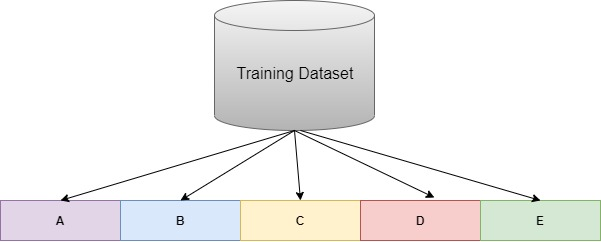

Now for each of these parts, we take them as validation one by one and rest of the parts for training. The unshaded or white box, represents the part among A, B, C, D, and E, that we take for validation. Rest are used for training in that particular fold.
Then we make two predictions (shown in the right hand side of the diagram):

**1. Predictions for the validation set:** This is also known as out-of-fold prediction.

**2. Predictions for the test set:** This is the dataset for which we need to submit our predictions to AV.

Finally if we combine the predictions for each of these folds we get OOFs or Out-of-Folds predictions. This is the prediction for the entire dataset. We can now see the performance our classifier on the entire training set.

Also we take the mean of the test predictions for each fold, and get our final test_predictions. We then need to round it to 0 or 1, since our metric demands we submit a discrete output, ie. no probabilities. 

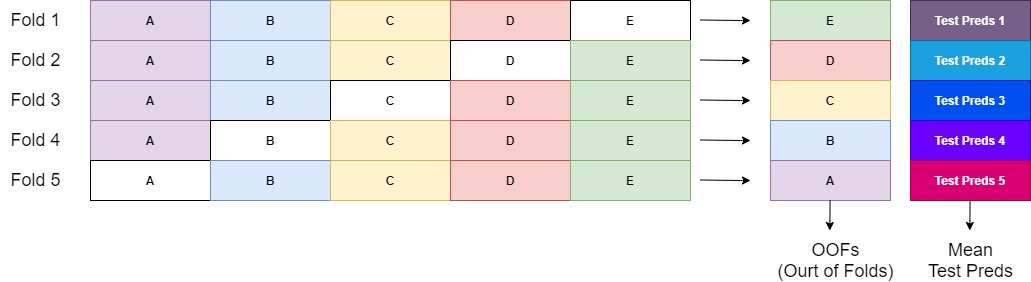

## **Stratified K-Fold.**

One obvious problem with normal KFold, is that each in each fold the distribution of classes in the validation set, will be not be same. This is a big problem with imbalanced datasets. 

In our above example its possible that in any of the splits we could have could have a validation set with no positive examples. 

To overcome this problem we will use Stratified-KFold Validation. StratifiedKFold ensures that each of the splits have same proportion of examples of each class.



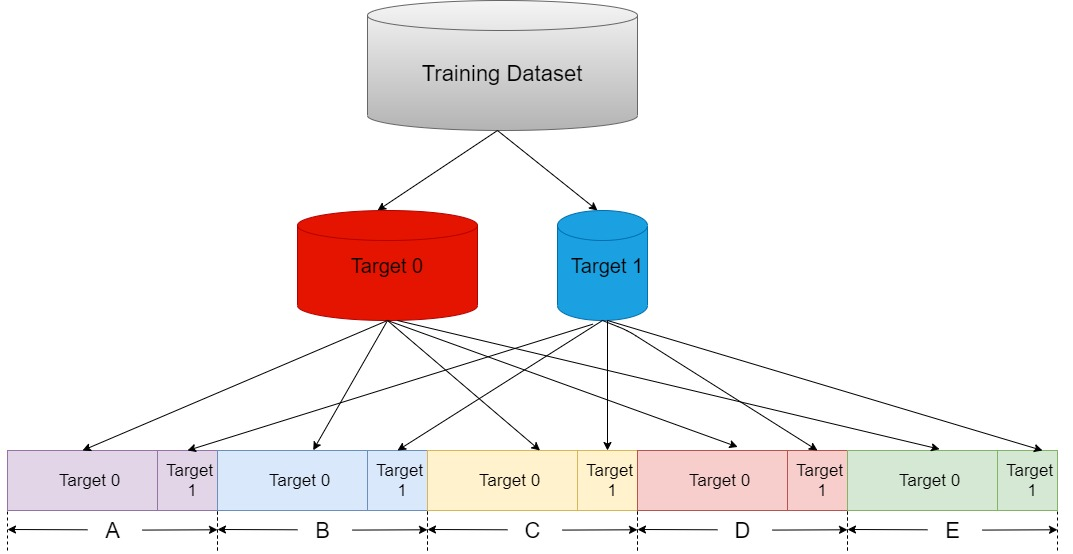

On a side note seeing so many arrows, reminds of Neural Networks.

Lets make our Decision Tree Model with Stratified KFold Validation

**Function to Run KFold**

In [ ]:
from sklearn.model_selection import StratifiedKFold

In [ ]:
def run_clf_kfold(clf, train, test, features):

  N_SPLITS = 5

  oofs = np.zeros(len(train))
  preds = np.zeros((len(test)))

  folds = StratifiedKFold(n_splits = N_SPLITS)

  for fold_, (trn_idx, val_idx) in enumerate(folds.split(train, train[TARGET_COL])):
    print(f'\n------------- Fold {fold_ + 1} -------------')

    ############# Get train, validation and test sets along with targets ################
  
    ### Training Set
    X_trn, y_trn = train[features].iloc[trn_idx], target.iloc[trn_idx]

    ### Validation Set
    X_val, y_val = train[features].iloc[val_idx], target.iloc[val_idx]

    ### Test Set
    X_test = test[features]

    ############# Scaling Data ################
    scaler = StandardScaler()
    _ = scaler.fit(X_trn)

    X_trn = scaler.transform(X_trn)
    X_val = scaler.transform(X_val)
    X_test = scaler.transform(X_test)


    ############# Fitting and Predicting ################

    _ = clf.fit(X_trn, y_trn)

    ### Instead of directly predicting the classes we will obtain the probability of positive class.
    preds_val = clf.predict_proba(X_val)[:, 1]
    preds_test = clf.predict_proba(X_test)[:, 1]

    fold_score = f1_score(y_val, preds_val.round())
    print(f'\nF1 score for validation set is {fold_score}')

    oofs[val_idx] = preds_val
    preds += preds_test / N_SPLITS


  oofs_score = f1_score(target, oofs.round())
  print(f'\n\nF1 score for oofs is {oofs_score}')

  return oofs, preds

**KFold on Decision Tree**

In [ ]:
target = train[TARGET_COL]

In [ ]:
dt_params = {'class_weight': {0: 1, 1: 5},
 'criterion': 'gini',
 'max_depth': 6,
 'max_features': 0.8,
 'max_leaf_nodes': 64,
 'min_samples_split': 20,
 'random_state': 1}

clf = DecisionTreeClassifier(**dt_params)
        

dt_oofs, dt_preds = run_clf_kfold(clf, train_proc, test_proc, features)


------------- Fold 1 -------------

F1 score for validation set is 0.37159253945480625

------------- Fold 2 -------------

F1 score for validation set is 0.371554950663491

------------- Fold 3 -------------

F1 score for validation set is 0.3699145299145299

------------- Fold 4 -------------

F1 score for validation set is 0.40550178298522666

------------- Fold 5 -------------

F1 score for validation set is 0.40491515506143944


F1 score for oofs is 0.3812074001947419


**Submitting on the Leaderboard**

In [ ]:
dt_preds_rounded = dt_preds.round()
download_preds(dt_preds_rounded, file_name = 'HR_Analytics_dt_5_folds.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

**0.5838**, little worse than our best LB score, but not much of a difference

# **Gradient Boosting**

Gradient boosting is a machine learning technique for regression and classification problems, which produces a prediction model in the form of an ensemble of weak prediction models, typically decision trees. It builds the model in a stage-wise fashion like other boosting methods do, and it generalizes them by allowing optimization of an arbitrary differentiable loss function.

https://en.wikipedia.org/wiki/Gradient_boosting

https://www.analyticsvidhya.com/blog/2020/02/4-boosting-algorithms-machine-learning/

Most Popular Variants of GradientBoosting
----------------------------

1. LightGBM

2. XGBoost

3. CatBoost

 ## **LightGBM**

LightGBM is a gradient boosting framework that uses tree based learning algorithms. It is designed to be distributed and efficient with the following advantages:

* Faster training speed and higher efficiency.

* Lower memory usage.

* Better accuracy.

* Support of parallel and GPU learning.

* Capable of handling large-scale data.

https://lightgbm.readthedocs.io/en/latest/

In [ ]:
from lightgbm import LGBMClassifier

In [ ]:
clf = LGBMClassifier()
lgb_oofs, lgb_preds = run_clf_kfold(clf, train_proc, test_proc, features)


------------- Fold 1 -------------

F1 score for validation set is 0.512214342001576

------------- Fold 2 -------------

F1 score for validation set is 0.4866562009419152

------------- Fold 3 -------------

F1 score for validation set is 0.4968553459119497

------------- Fold 4 -------------

F1 score for validation set is 0.5272161741835147

------------- Fold 5 -------------

F1 score for validation set is 0.5027494108405341


F1 score for oofs is 0.5051772827110135


**Submitting on the Leaderboard**

In [ ]:
lgb_preds_rounded = lgb_preds.round()
download_preds(lgb_preds_rounded, file_name = 'HR_Analytics_lgb_5_folds.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

**0.4755**, quite bad for some model like LGB, What could be the problem ?


In [ ]:
preds = np.array([0.2, 0.4, 0.35, 0.7, 0.21])
preds.round()

array([0., 0., 0., 1., 0.])

### **Hacking F1_Score or Threshold optimization**

Rounding off means you are selecting a threshold of 0.5. Any predictions with probabilities greater than or equal to 0.5 will be rounded to 1, rest will be rounded to 0.

But is 0.5 the best threshold to get an optimal F1-score ?

Lets verify it ourselves by running all threholds from 0.01,0.02 to 0.99.

In [ ]:
thresholds = np.arange(0, 100)/100
for thresh in thresholds:
  oofs_rounded = (lgb_oofs > thresh) * 1
  thresh_score = f1_score(target, oofs_rounded)
  print(f'Threshold {thresh}: {thresh_score}')

Threshold 0.0: 0.15697087901002085
Threshold 0.01: 0.29493554619453327
Threshold 0.02: 0.3162252788612879
Threshold 0.03: 0.332957562093167
Threshold 0.04: 0.3413609423062495
Threshold 0.05: 0.34742505764796305
Threshold 0.06: 0.3528436673639342
Threshold 0.07: 0.3586588992544914
Threshold 0.08: 0.36755107230651857
Threshold 0.09: 0.3791608954023502
Threshold 0.1: 0.3913951942254725
Threshold 0.11: 0.4011577717970853
Threshold 0.12: 0.4149840008827099
Threshold 0.13: 0.43029321820471317
Threshold 0.14: 0.44022302904564314
Threshold 0.15: 0.45535336436732965
Threshold 0.16: 0.46713650988202854
Threshold 0.17: 0.4774931609052475
Threshold 0.18: 0.48671854038100354
Threshold 0.19: 0.4949717460013408
Threshold 0.2: 0.5045741004269161
Threshold 0.21: 0.506426735218509
Threshold 0.22: 0.5111712931618145
Threshold 0.23: 0.5117971592909967
Threshold 0.24: 0.5109649122807018
Threshold 0.25: 0.5137150802679814
Threshold 0.26: 0.5156939040207522
Threshold 0.27: 0.5156581740976646
Threshold 0.28: 

In [ ]:
def get_optimal_f1_thresh(target, oofs):
  thresholds = np.arange(0, 100)/100
  thresh_scores = []
  for thresh in thresholds:
    oofs_rounded = (lgb_oofs > thresh) * 1
    thresh_score = f1_score(target, oofs_rounded)
    thresh_scores.append(thresh_score)
  
  all_thresholds_and_scores = pd.Series(index = thresholds, data = thresh_scores)
  all_thresholds_and_scores.plot(figsize=(10, 6), fontsize=14)
  
  plt.xlabel('Threshold', fontsize=14)
  plt.ylabel('F1 Score', fontsize=14)

  return all_thresholds_and_scores.sort_values(ascending=False).index.values[0]

Optimal threhold is 0.38


0.5186753364584908

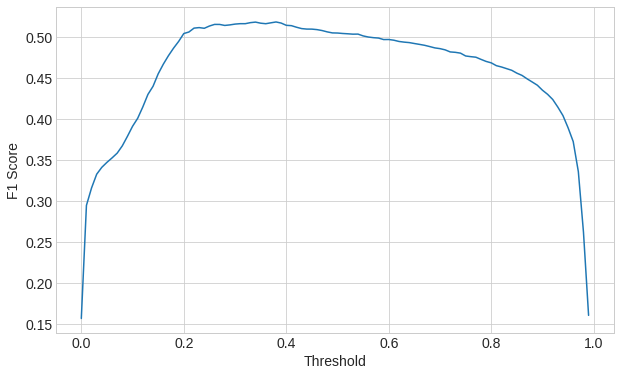

In [ ]:
optimal_thresh = get_optimal_f1_thresh(target, lgb_oofs)
print(f'Optimal threhold is {optimal_thresh}')
f1_score(target, (lgb_oofs > optimal_thresh) * 1)

**Submitting on the Leaderboard**

In [ ]:
lgb_preds_rounded = (lgb_preds > optimal_thresh) * 1
download_preds(lgb_preds_rounded, file_name = 'HR_Analytics_lgb_5_folds_threshold_optimized.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

**0.5101**, now that's the LGB we know.

### **Tuning LightGBM**

* Early Stopping: Stopping the model training, when the model starts to overfit
  * How do we know if model is overfitting ?
* HyperParameter Optimization.
  * Is random search the best way to go ?

**Simple Function to Run Gradient Boosting**

Let's make a simple function to call gradient boosting and get our oofs and predictions. Rather than copying and pasting the same code again and again/

In [ ]:
def run_gradient_boosting(clf, fit_params, train, test, features):
  N_SPLITS = 5
  oofs = np.zeros(len(train_proc))
  preds = np.zeros((len(test_proc)))

  folds = StratifiedKFold(n_splits = N_SPLITS)

  for fold_, (trn_idx, val_idx) in enumerate(folds.split(train, train[TARGET_COL])):
    print(f'\n------------- Fold {fold_ + 1} -------------')

    ### Training Set
    X_trn, y_trn = train[features].iloc[trn_idx], target.iloc[trn_idx]

    ### Validation Set
    X_val, y_val = train[features].iloc[val_idx], target.iloc[val_idx]

    ### Test Set
    X_test = test[features]

    scaler = StandardScaler()
    _ = scaler.fit(X_trn)

    X_trn = scaler.transform(X_trn)
    X_val = scaler.transform(X_val)
    X_test = scaler.transform(X_test)
    
    _ = clf.fit(X_trn, y_trn, eval_set = [(X_val, y_val)], **fit_params)

    ### Instead of directly predicting the classes we will obtain the probability of positive class.
    preds_val = clf.predict_proba(X_val)[:, 1]
    preds_test = clf.predict_proba(X_test)[:, 1]

    fold_score = f1_score(y_val, preds_val.round())
    print(f'\nF1 score for validation set is {fold_score}')

    oofs[val_idx] = preds_val
    preds += preds_test / N_SPLITS


  oofs_score = f1_score(target, oofs.round())
  print(f'\n\nF1 score for oofs is {oofs_score}')

  return oofs, preds

**Manual Tuning. Choosing Hyperparameters to Tune**


------------- Fold 1 -------------
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0.163376
[200]	valid_0's binary_logloss: 0.161719
Early stopping, best iteration is:
[199]	valid_0's binary_logloss: 0.161707

F1 score for validation set is 0.5133858267716536

------------- Fold 2 -------------
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0.166758
[200]	valid_0's binary_logloss: 0.164992
[300]	valid_0's binary_logloss: 0.164947
Early stopping, best iteration is:
[214]	valid_0's binary_logloss: 0.164723

F1 score for validation set is 0.48807631160572335

------------- Fold 3 -------------
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0.167571
[200]	valid_0's binary_logloss: 0.1656
Early stopping, best iteration is:
[182]	valid_0's binary_logloss: 0.165554

F1 score for validation set is 0.4968454258675079

------------- Fold 4 -------------


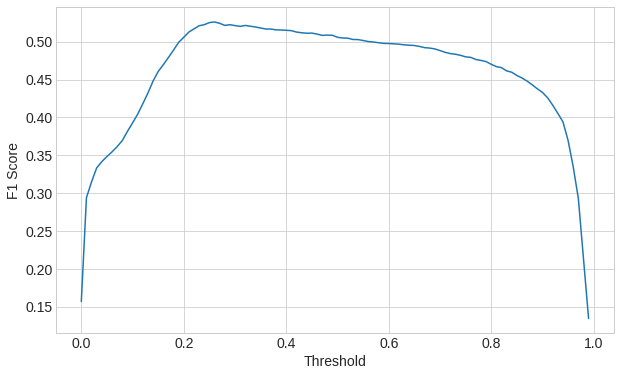

In [ ]:
clf = LGBMClassifier(n_estimators = 1000,
                        learning_rate = 0.05,
                        colsample_bytree = 0.76,
                        )
fit_params = {'verbose': 100, 'early_stopping_rounds': 100}

lgb_oofs, lgb_preds = run_gradient_boosting(clf, fit_params, train_proc, test_proc, features)

optimal_thresh = get_optimal_f1_thresh(target, lgb_oofs)
print(f'Optimal threhold is {optimal_thresh}')
optimized_f1 = f1_score(target, (lgb_oofs > optimal_thresh) * 1)
print(f'Optimized F1 is {optimized_f1}')

**Submitting on the Leaderboard**

In [ ]:
lgb_preds_rounded = (lgb_preds > optimal_thresh) * 1
download_preds(lgb_preds_rounded, file_name = 'HR_Analytics_lgb_5_folds_hyperparameter_tuned.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

**0.5181**, CV increased but LB decreased :(

**Tuning Learning Rate**


------------- Fold 1 -------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's binary_logloss: 0.18714
[400]	valid_0's binary_logloss: 0.169031
[600]	valid_0's binary_logloss: 0.163415
[800]	valid_0's binary_logloss: 0.162186
[1000]	valid_0's binary_logloss: 0.161719
[1200]	valid_0's binary_logloss: 0.161486
[1400]	valid_0's binary_logloss: 0.161374
[1600]	valid_0's binary_logloss: 0.16129
[1800]	valid_0's binary_logloss: 0.161359
Early stopping, best iteration is:
[1618]	valid_0's binary_logloss: 0.161286

F1 score for validation set is 0.5055292259083728

------------- Fold 2 -------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's binary_logloss: 0.188861
[400]	valid_0's binary_logloss: 0.171557
[600]	valid_0's binary_logloss: 0.165957
[800]	valid_0's binary_logloss: 0.164913
[1000]	valid_0's binary_logloss: 0.164581
[1200]	valid_0's binary_logloss: 0.164586
Early stopping, best iteration is:
[1073]	valid_0's bi

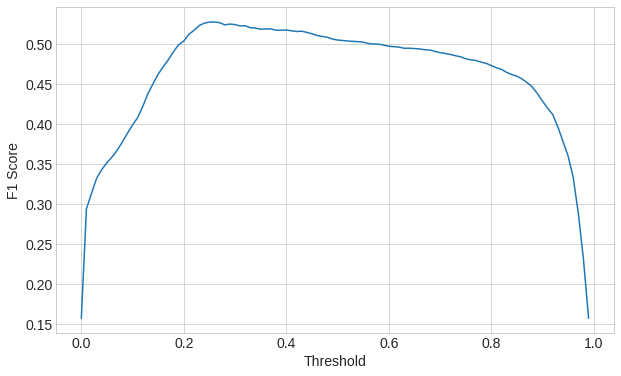

In [ ]:
clf = LGBMClassifier(n_estimators = 2000,
                     learning_rate = 0.01,
                     colsample_bytree = 0.65,
                     random_state = 2)
fit_params = {'verbose': 200, 'early_stopping_rounds': 200}

lgb_oofs, lgb_preds = run_gradient_boosting(clf, fit_params, train_proc, test_proc, features)

optimal_thresh = get_optimal_f1_thresh(target, lgb_oofs)
print(f'Optimal threhold is {optimal_thresh}')
optimized_f1 = f1_score(target, (lgb_oofs > optimal_thresh) * 1)
print(f'Optimized F1 is {optimized_f1}')

**Submitting on the Leaderboard**

In [ ]:
lgb_preds_rounded = (lgb_preds > optimal_thresh) * 1
download_preds(lgb_preds_rounded, file_name = 'HR_Analytics_lgb_5_folds_learning_rate_tuned.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

**0.5129**, CV and LB both increased Yay :D

Enough of LightGBM, lets now look at other libraries

## **CatBoost**

CatBoost is a high-performance open source library for gradient boosting on decision trees.

Features

* Great quality without parameter tuning: Reduce time spent on parameter tuning, because CatBoost provides great results with default parameters

* Categorical features support: Improve your training results with CatBoost that allows you to use non-numeric factors, instead of having to pre-process your data or spend time and effort turning it to numbers.

* Fast and scalable GPU version: Train your model on a fast implementation of gradient-boosting algorithm for GPU. Use a multi-card configuration for large datasets.

* Improved accuracy: Reduce overfitting when constructing your models with a novel gradient-boosting scheme.

* Fast prediction: Apply your trained model quickly and efficiently even to latency-critical tasks using CatBoost's model applier

https://catboost.ai/


------------- Fold 1 -------------
0:	learn: 0.6804593	test: 0.6804608	best: 0.6804608 (0)	total: 80.5ms	remaining: 4m 1s
200:	learn: 0.2096125	test: 0.2102940	best: 0.2102940 (200)	total: 4.5s	remaining: 1m 2s
400:	learn: 0.1809562	test: 0.1827133	best: 0.1827133 (400)	total: 8.88s	remaining: 57.5s
600:	learn: 0.1705530	test: 0.1736114	best: 0.1736114 (600)	total: 13.3s	remaining: 53.3s
800:	learn: 0.1649956	test: 0.1693521	best: 0.1693521 (800)	total: 17.8s	remaining: 48.8s
1000:	learn: 0.1611894	test: 0.1667656	best: 0.1667656 (1000)	total: 22.1s	remaining: 44.2s
1200:	learn: 0.1581849	test: 0.1650286	best: 0.1650286 (1200)	total: 26.5s	remaining: 39.8s
1400:	learn: 0.1553455	test: 0.1636497	best: 0.1636497 (1400)	total: 31s	remaining: 35.4s
1600:	learn: 0.1531092	test: 0.1628000	best: 0.1628000 (1600)	total: 35.5s	remaining: 31s
1800:	learn: 0.1511742	test: 0.1622519	best: 0.1622519 (1800)	total: 39.9s	remaining: 26.6s
2000:	learn: 0.1494757	test: 0.1618343	best: 0.1618331 (1976)	

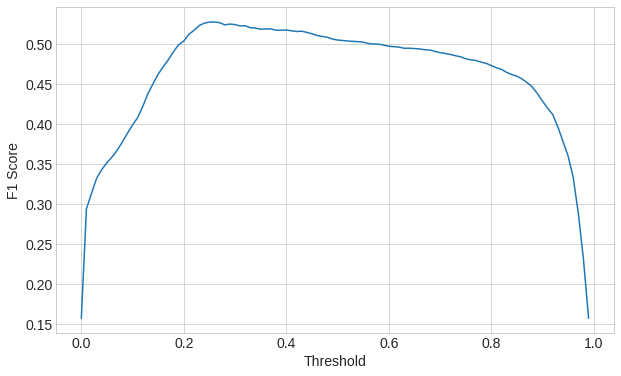

In [ ]:
clf = CatBoostClassifier(n_estimators = 3000,
                       learning_rate = 0.01,
                       rsm = 0.4, ## Analogous to colsample_bytree
                       random_state=2054,
                       )

fit_params = {'verbose': 200, 'early_stopping_rounds': 200}

cb_oofs, cb_preds = run_gradient_boosting(clf, fit_params, train_proc, test_proc, features)

optimal_thresh = get_optimal_f1_thresh(target, cb_oofs)
print(f'Optimal threhold is {optimal_thresh}')
optimized_f1 = f1_score(target, (cb_oofs > optimal_thresh) * 1)
print(f'Optimized F1 is {optimized_f1}')

**Submitting on the Leaderboard**

In [ ]:

cb_preds_rounded = (cb_preds > optimal_thresh) * 1
download_preds(cb_preds_rounded, file_name = 'HR_Analytics_cb_5_folds.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

**0.5211**, amazing improvement in both CV and LB yay :D

**CatBoost: gives Improvement from 0.5129 to 0.5211 on LB**.

* Is catboost better then LightGBM ?
* Can catboost score be further improved ?
* Can LighGBM be tuned to give a better score than CatBoost ?

## **XGBoost**

XGBoost is an optimized distributed gradient boosting library designed to be highly efficient, flexible and portable. It implements machine learning algorithms under the Gradient Boosting framework. XGBoost provides a parallel tree boosting (also known as GBDT, GBM) that solve many data science problems in a fast and accurate way. The same code runs on major distributed environment (Hadoop, SGE, MPI) and can solve problems beyond billions of examples.

https://xgboost.readthedocs.io/en/latest/


------------- Fold 1 -------------
[0]	validation_0-error:0.083744
Will train until validation_0-error hasn't improved in 200 rounds.
[200]	validation_0-error:0.057654
[400]	validation_0-error:0.056559
Stopping. Best iteration:
[256]	validation_0-error:0.056377


F1 score for validation set is 0.5103011093502378

------------- Fold 2 -------------
[0]	validation_0-error:0.084565
Will train until validation_0-error hasn't improved in 200 rounds.
[200]	validation_0-error:0.060482
[400]	validation_0-error:0.058748
Stopping. Best iteration:
[394]	validation_0-error:0.058748


F1 score for validation set is 0.4921135646687697

------------- Fold 3 -------------
[0]	validation_0-error:0.082375
Will train until validation_0-error hasn't improved in 200 rounds.
[200]	validation_0-error:0.058475
[400]	validation_0-error:0.057562
Stopping. Best iteration:
[315]	validation_0-error:0.05738


F1 score for validation set is 0.5043341213553979

------------- Fold 4 -------------
[0]	validation_0-err

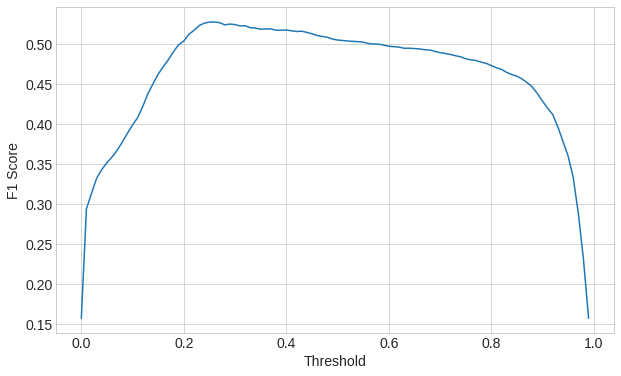

In [ ]:
clf = XGBClassifier(n_estimators = 1000,
                    max_depth = 6,
                    learning_rate = 0.05,
                    colsample_bytree = 0.5,
                    random_state=1452,
                    )

fit_params = {'verbose': 200, 'early_stopping_rounds': 200}

xgb_oofs, xgb_preds = run_gradient_boosting(clf, fit_params, train_proc, test_proc, features)

optimal_thresh = get_optimal_f1_thresh(target, xgb_oofs)
print(f'Optimal threhold is {optimal_thresh}')
optimized_f1 = f1_score(target, (xgb_oofs > optimal_thresh) * 1)
print(f'Optimized F1 is {optimized_f1}')

**Submitting on the Leaderboard**

In [ ]:
xgb_preds_rounded = (xgb_preds > optimal_thresh) * 1
download_preds(xgb_preds_rounded, file_name = 'HR_Analytics_xgbb_5_folds.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

**0.5080**, decrease in both CV and LB

**Questions to think about XGBoost**

* Is XGBoost worse than LightGBM and CatBoost ?

* Can XGBoost be tuned more ?



# **Feature Engineering**

* What does a model know about a sample ?

* What the model does not know about the sample ?

* How do we provide that unknown information to the model ?


***Feature Engineering is one of the biggest difference maker in any ML competition.*** 

<br>
<br>

**Helper Functions**

In [ ]:
def join_df(train, test):

  df = pd.concat([train, test], axis=0).reset_index(drop = True)
  features = [c for c in df.columns if c not in [ID_COL, TARGET_COL]]

  return df, features

def split_df_and_get_features(df, train_nrows):

  train, test = df[:train_nrows].reset_index(drop = True), df[train_nrows:].reset_index(drop = True)
  features = [c for c in train.columns if c not in [ID_COL, TARGET_COL]]
  
  return train, test, features

In [ ]:
cat_cols

['department',
 'region',
 'education',
 'gender',
 'recruitment_channel',
 'KPIs_met >80%',
 'awards_won?']

In [ ]:
train.head()

,employee_id,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score,is_promoted
0,65438,Sales & Marketing,region_7,Master's & above,f,sourcing,1,35,5.0,8,1,0,49,0
1,65141,Operations,region_22,Bachelor's,m,other,1,30,5.0,4,0,0,60,0
2,7513,Sales & Marketing,region_19,Bachelor's,m,sourcing,1,34,3.0,7,0,0,50,0
3,2542,Sales & Marketing,region_23,Bachelor's,m,other,2,39,1.0,10,0,0,50,0
4,48945,Technology,region_26,Bachelor's,m,other,1,45,3.0,2,0,0,73,0


In [ ]:
df, features = join_df(train, test)

In [ ]:
df.head()

,employee_id,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score,is_promoted
0,65438,Sales & Marketing,region_7,Master's & above,f,sourcing,1,35,5.0,8,1,0,49,0.0
1,65141,Operations,region_22,Bachelor's,m,other,1,30,5.0,4,0,0,60,0.0
2,7513,Sales & Marketing,region_19,Bachelor's,m,sourcing,1,34,3.0,7,0,0,50,0.0
3,2542,Sales & Marketing,region_23,Bachelor's,m,other,2,39,1.0,10,0,0,50,0.0
4,48945,Technology,region_26,Bachelor's,m,other,1,45,3.0,2,0,0,73,0.0


In [ ]:
df.select_dtypes('object').columns.tolist()

['department', 'region', 'education', 'gender', 'recruitment_channel']

In [ ]:
df, features = join_df(train, test)

### Label Encoding
df[cat_cols] = df[cat_cols].apply(lambda x: pd.factorize(x)[0])

#### No NaN filling required.

Are we missing something compared to our previous set of steps ?

<br>
<br>
<br>
<br>
<br>
<br>

**NaN filling is not required**

In [ ]:
df.head()

,employee_id,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score,is_promoted
0,65438,0,0,0,0,0,1,35,5.0,8,0,0,49,0.0
1,65141,1,1,1,1,1,1,30,5.0,4,1,0,60,0.0
2,7513,0,2,1,1,0,1,34,3.0,7,1,0,50,0.0
3,2542,0,3,1,1,1,2,39,1.0,10,1,0,50,0.0
4,48945,2,4,1,1,1,1,45,3.0,2,1,0,73,0.0


## **Frequency Features**

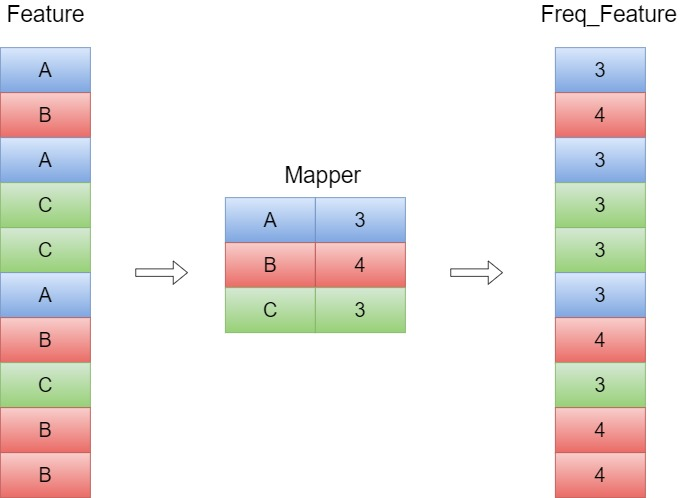

In [ ]:
df['department'].value_counts()

0    24155
1    16112
5    10158
2    10149
3    7671 
6    3627 
7    3503 
8    1484 
4    1439 
Name: department, dtype: int64

In [ ]:
df['department'].head()

0    0
1    1
2    0
3    0
4    2
Name: department, dtype: int64

In [ ]:
df['department'].map(df['department'].value_counts())

0        24155
1        16112
2        24155
3        24155
4        10149
         ...  
78293    1484 
78294    10149
78295    3503 
78296    10158
78297    10149
Name: department, Length: 78298, dtype: int64

In [ ]:
def get_frequency_features(df, cols):

  df[[c + '_freq' for c in cols]] = df[cols].apply(lambda x: x.map(x.value_counts()))
  
  return df

In [ ]:
freq_cols = [c for c in cat_cols if (train[c].nunique() > 3) and (train[c].nunique() < 100)]
freq_cols

['department', 'region']

In [ ]:
df = get_frequency_features(df, freq_cols)
train_proc, test_proc, features = split_df_and_get_features(df, train.shape[0])


------------- Fold 1 -------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's binary_logloss: 0.212531
[400]	valid_0's binary_logloss: 0.191925
[600]	valid_0's binary_logloss: 0.181156
[800]	valid_0's binary_logloss: 0.174183
[1000]	valid_0's binary_logloss: 0.170502
[1200]	valid_0's binary_logloss: 0.167982
[1400]	valid_0's binary_logloss: 0.165792
[1600]	valid_0's binary_logloss: 0.164807
[1800]	valid_0's binary_logloss: 0.16432
[2000]	valid_0's binary_logloss: 0.163682
Did not meet early stopping. Best iteration is:
[1998]	valid_0's binary_logloss: 0.163682

F1 score for validation set is 0.5055292259083728

------------- Fold 2 -------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's binary_logloss: 0.215312
[400]	valid_0's binary_logloss: 0.194668
[600]	valid_0's binary_logloss: 0.183695
[800]	valid_0's binary_logloss: 0.177199
[1000]	valid_0's binary_logloss: 0.173642
[1200]	valid_0's binary_logloss: 0.17107

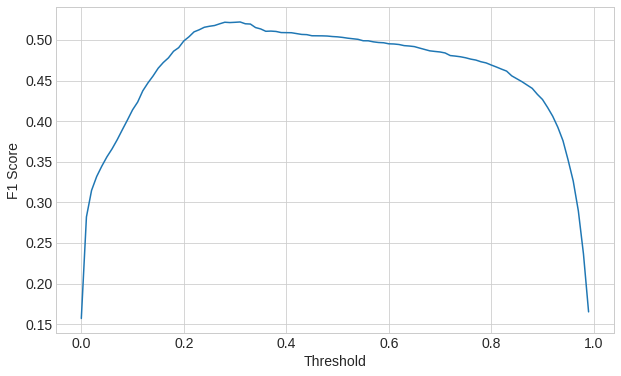

In [ ]:
clf = LGBMClassifier(n_estimators = 2000,
                        learning_rate = 0.01,
                        colsample_bytree = 0.4,
                        reg_alpha = 1,
                        reg_lambda = 1
                        )
fit_params = {'verbose': 200, 'early_stopping_rounds': 200}
lgb_oofs, lgb_preds = run_gradient_boosting(clf, fit_params, train_proc, test_proc, features)

optimal_thresh = get_optimal_f1_thresh(target, lgb_oofs)
print(f'Optimal threhold is {optimal_thresh}')
optimized_f1 = f1_score(target, (lgb_oofs > optimal_thresh) * 1)
print(f'Optimized F1 is {optimized_f1}')

## **Interaction Features**

Can any two features be combined to make more sense in the given dataset ?

In [ ]:
df.head()

,employee_id,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score,is_promoted,department_freq,region_freq
0,65438,0,0,0,0,0,1,35,5.0,8,0,0,49,0.0,24155,6825
1,65141,1,1,1,1,1,1,30,5.0,4,1,0,60,0.0,16112,9167
2,7513,0,2,1,1,0,1,34,3.0,7,1,0,50,0.0,24155,1284
3,2542,0,3,1,1,1,2,39,1.0,10,1,0,50,0.0,24155,1691
4,48945,2,4,1,1,1,1,45,3.0,2,1,0,73,0.0,10149,3271


In [ ]:
df[['month', 'day_of_month']].head()

,month,day_of_month
0,0,26
1,1,18
2,2,5
3,3,20
4,3,13


In [ ]:
df['month_and_day_of_month'] = pd.factorize(df['month'].astype('str') + df['day_of_month'].astype('str'))[0]

In [ ]:
df['month_and_day_of_month']

0        0  
1        1  
2        2  
3        3  
4        4  
        ..  
45206    139
45207    41 
45208    108
45209    4  
45210    92 
Name: month_and_day_of_month, Length: 45211, dtype: int64

In [ ]:
df['month_and_day_of_month'].nunique()

311

In [ ]:
train_proc, test_proc, features = split_df_and_get_features(df, train.shape[0])


------------- Fold 1 -------------
Training until validation scores don't improve for 400 rounds.
[200]	valid_0's binary_logloss: 0.207034
[400]	valid_0's binary_logloss: 0.179554
[600]	valid_0's binary_logloss: 0.169858
[800]	valid_0's binary_logloss: 0.165635
[1000]	valid_0's binary_logloss: 0.163723
[1200]	valid_0's binary_logloss: 0.162504
[1400]	valid_0's binary_logloss: 0.16176
[1600]	valid_0's binary_logloss: 0.161409
[1800]	valid_0's binary_logloss: 0.161364
[2000]	valid_0's binary_logloss: 0.161416
Early stopping, best iteration is:
[1664]	valid_0's binary_logloss: 0.161346

F1 score for validation set is 0.582716049382716

------------- Fold 2 -------------
Training until validation scores don't improve for 400 rounds.
[200]	valid_0's binary_logloss: 0.204002
[400]	valid_0's binary_logloss: 0.176246
[600]	valid_0's binary_logloss: 0.166566
[800]	valid_0's binary_logloss: 0.162407
[1000]	valid_0's binary_logloss: 0.160111
[1200]	valid_0's binary_logloss: 0.158753
[1400]	valid

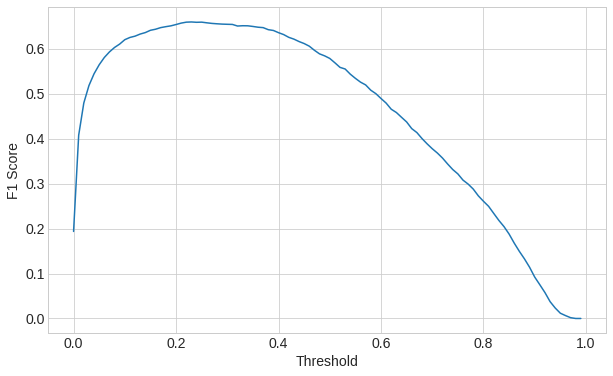

In [ ]:
clf = LGBMClassifier(n_estimators = 3000,
                        learning_rate = 0.01,
                        colsample_bytree = 0.38,
                        reg_alpha = 1,
                        reg_lambda = 1,
                        )
fit_params = {'verbose': 200, 'early_stopping_rounds': 400}
lgb_oofs, lgb_preds = run_gradient_boosting(clf, fit_params, train_proc, test_proc, features)

optimal_thresh = get_optimal_f1_thresh(target, lgb_oofs)
print(f'Optimal threhold is {optimal_thresh}')
optimized_f1 = f1_score(target, (lgb_oofs > optimal_thresh) * 1)
print(f'Optimized F1 is {optimized_f1}')

**EDA and features from EDA**

In [ ]:
df['month_and_day_of_month'].value_counts()

47     1126
31     1011
4      1002
11     891 
45     841 
      ...  
308    1   
309    1   
293    1   
310    1   
300    1   
Name: month_and_day_of_month, Length: 311, dtype: int64

In [ ]:
df = get_frequency_features(df, ['month_and_day_of_month'])
train_proc, test_proc, features = split_df_and_get_features(df, train.shape[0])

In [ ]:
lgb_preds_rounded = (lgb_preds > optimal_thresh) * 1
download_preds(lgb_preds_rounded, file_name = 'hacklive_lgb_5_folds_fe.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
train['education'].map({'primary': 1, 'secondary': 2, 'tertiary': 3})

0        3.0
1        2.0
2        2.0
3        2.0
4        1.0
        ... 
31642    2.0
31643    3.0
31644    1.0
31645    2.0
31646    3.0
Name: education, Length: 31647, dtype: float64


------------- Fold 1 -------------
Training until validation scores don't improve for 400 rounds.
[200]	valid_0's binary_logloss: 0.207293
[400]	valid_0's binary_logloss: 0.178549
[600]	valid_0's binary_logloss: 0.169959
[800]	valid_0's binary_logloss: 0.165109
[1000]	valid_0's binary_logloss: 0.163458
[1200]	valid_0's binary_logloss: 0.161927
[1400]	valid_0's binary_logloss: 0.161026
[1600]	valid_0's binary_logloss: 0.160614
[1800]	valid_0's binary_logloss: 0.160538
[2000]	valid_0's binary_logloss: 0.160391
[2200]	valid_0's binary_logloss: 0.16044
[2400]	valid_0's binary_logloss: 0.160494
Early stopping, best iteration is:
[2075]	valid_0's binary_logloss: 0.160337

F1 score for validation set is 0.5905383360522023

------------- Fold 2 -------------
Training until validation scores don't improve for 400 rounds.
[200]	valid_0's binary_logloss: 0.203244
[400]	valid_0's binary_logloss: 0.174633
[600]	valid_0's binary_logloss: 0.166271
[800]	valid_0's binary_logloss: 0.161494
[1000]	vali

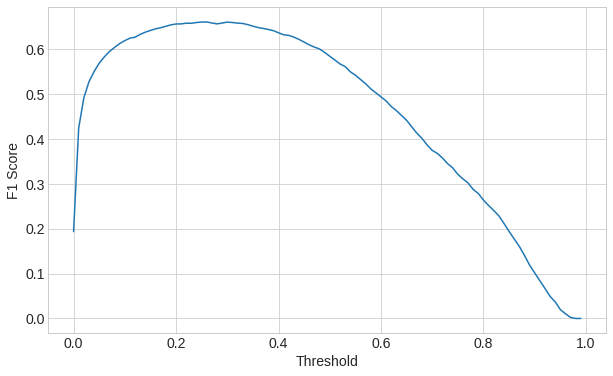

In [ ]:
clf = LGBMClassifier(n_estimators = 3000,
                        learning_rate = 0.01,
                        colsample_bytree = 0.38,
                        reg_alpha = 1,
                        reg_lambda = 1,
                        )
fit_params = {'verbose': 200, 'early_stopping_rounds': 400}
lgb_oofs, lgb_preds = run_gradient_boosting(clf, fit_params, train_proc, test_proc, features)

optimal_thresh = get_optimal_f1_thresh(target, lgb_oofs)
print(f'Optimal threhold is {optimal_thresh}')
optimized_f1 = f1_score(target, (lgb_oofs > optimal_thresh) * 1)
print(f'Optimized F1 is {optimized_f1}')

In [ ]:
lgb_preds_rounded = (lgb_preds > optimal_thresh) * 1
download_preds(lgb_preds_rounded, file_name = 'hacklive_lgb_5_folds_fe_freq.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## **Grouping Features**

In [ ]:
df['mean_age_for_customer_on_month_and_day_of_month'] = df.groupby('month_and_day_of_month')['customer_age'].transform('mean')
train_proc, test_proc, features = split_df_and_get_features(df, train.shape[0])


------------- Fold 1 -------------
Training until validation scores don't improve for 400 rounds.
[200]	valid_0's binary_logloss: 0.202053
[400]	valid_0's binary_logloss: 0.17671
[600]	valid_0's binary_logloss: 0.16704
[800]	valid_0's binary_logloss: 0.163316
[1000]	valid_0's binary_logloss: 0.161244
[1200]	valid_0's binary_logloss: 0.160354
[1400]	valid_0's binary_logloss: 0.160107
[1600]	valid_0's binary_logloss: 0.159898
[1800]	valid_0's binary_logloss: 0.159865
[2000]	valid_0's binary_logloss: 0.159911
Early stopping, best iteration is:
[1705]	valid_0's binary_logloss: 0.159833

F1 score for validation set is 0.5842880523731587

------------- Fold 2 -------------
Training until validation scores don't improve for 400 rounds.
[200]	valid_0's binary_logloss: 0.199161
[400]	valid_0's binary_logloss: 0.173862
[600]	valid_0's binary_logloss: 0.164341
[800]	valid_0's binary_logloss: 0.160841
[1000]	valid_0's binary_logloss: 0.158901
[1200]	valid_0's binary_logloss: 0.158041
[1400]	valid

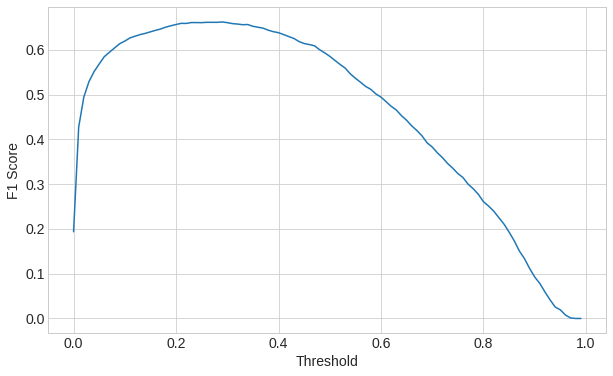

In [ ]:
clf = LGBMClassifier(n_estimators = 3000,
                        learning_rate = 0.01,
                        colsample_bytree = 0.38,
                        reg_alpha = 1,
                        reg_lambda = 1,
                        )
fit_params = {'verbose': 200, 'early_stopping_rounds': 400}
lgb_oofs, lgb_preds = run_gradient_boosting(clf, fit_params, train_proc, test_proc, features)

optimal_thresh = get_optimal_f1_thresh(target, lgb_oofs)
print(f'Optimal threhold is {optimal_thresh}')
optimized_f1 = f1_score(target, (lgb_oofs > optimal_thresh) * 1)
print(f'Optimized F1 is {optimized_f1}')

In [ ]:
lgb_preds_rounded = (lgb_preds > optimal_thresh) * 1
download_preds(lgb_preds_rounded, file_name = 'hacklive_lgb_5_folds_fe_freq_grouped.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# **Ensembling**




In statistics and machine learning, ensemble methods use multiple learning algorithms to obtain better predictive performance than could be obtained from any of the constituent learning algorithms alone.



* What are our best performing algorithms ?
* How do we combine these algorithms to get a better performance ?

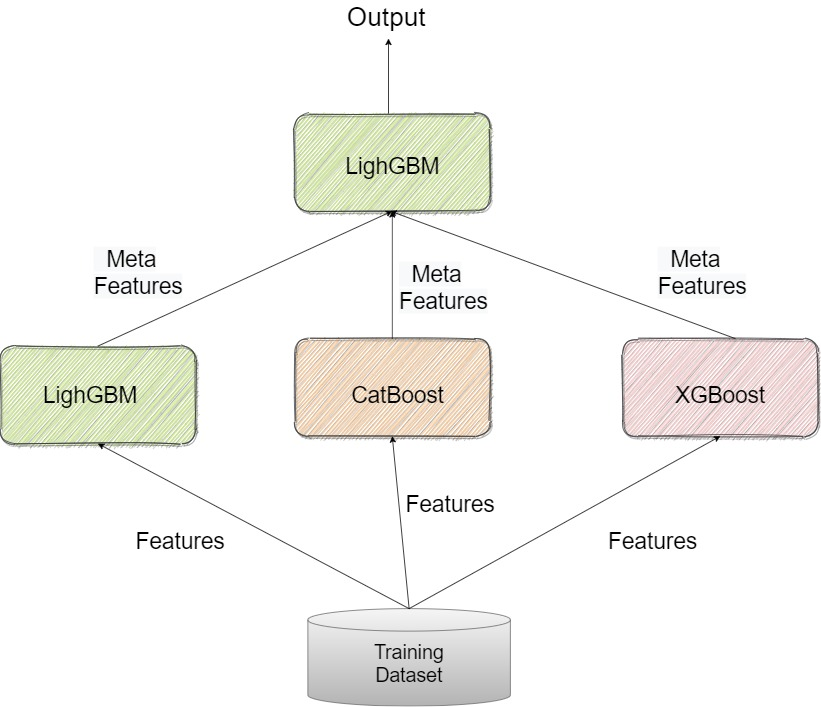

To read more about ensembling go here:

https://bit.ly/2SFgrnb

In [ ]:
train_new = train[[ID_COL, TARGET_COL]]
test_new = test[[ID_COL]]

train_new['lgb'] = lgb_oofs
test_new['lgb'] = lgb_preds

train_new['cb'] = cb_oofs
test_new['cb'] = cb_preds

train_new['xgb'] = xgb_oofs
test_new['xgb'] = xgb_preds

features = [c for c in train_new.columns if c not in [ID_COL, TARGET_COL]]

In [ ]:
features

['lgb', 'cb', 'xgb']


------------- Fold 1 -------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's binary_logloss: 0.169265
[400]	valid_0's binary_logloss: 0.161592
[600]	valid_0's binary_logloss: 0.161117
Early stopping, best iteration is:
[542]	valid_0's binary_logloss: 0.161063

F1 score for validation set is 0.5035742652899127

------------- Fold 2 -------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's binary_logloss: 0.171508
[400]	valid_0's binary_logloss: 0.163653
[600]	valid_0's binary_logloss: 0.163246
Early stopping, best iteration is:
[520]	valid_0's binary_logloss: 0.163172

F1 score for validation set is 0.48807631160572335

------------- Fold 3 -------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's binary_logloss: 0.172001
[400]	valid_0's binary_logloss: 0.164755
[600]	valid_0's binary_logloss: 0.164321
Early stopping, best iteration is:
[505]	valid_0's binary_logloss: 0.164278

F1

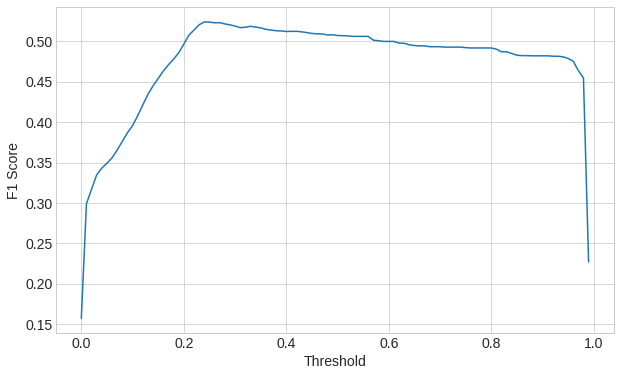

In [ ]:
clf = LGBMClassifier(n_estimators = 2000,
                        learning_rate = 0.01,
                        colsample_bytree = 0.75,
                        reg_alpha=1,
                        reg_lambda=1,
                        )
fit_params = {'verbose': 200, 'early_stopping_rounds': 200}
lgb_oofs, lgb_preds = run_gradient_boosting(clf, fit_params, train_new, test_new, features)

optimal_thresh = get_optimal_f1_thresh(target, lgb_oofs)
print(f'Optimal threhold is {optimal_thresh}')
optimized_f1 = f1_score(target, (lgb_oofs > optimal_thresh) * 1)
print(f'Optimized F1 is {optimized_f1}')

In [ ]:
lgb_preds_rounded = (lgb_preds > optimal_thresh) * 1
download_preds(lgb_preds_rounded, file_name = 'HR_Analytics_stacked_lgb.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

**Cat Boost**


------------- Fold 1 -------------
0:	learn: 0.6763578	test: 0.6762908	best: 0.6762908 (0)	total: 15.7ms	remaining: 47s
200:	learn: 0.1686053	test: 0.1681696	best: 0.1681696 (200)	total: 3.2s	remaining: 44.6s
400:	learn: 0.1613532	test: 0.1605580	best: 0.1605580 (400)	total: 6.34s	remaining: 41.1s
600:	learn: 0.1600804	test: 0.1597015	best: 0.1597015 (600)	total: 9.47s	remaining: 37.8s
800:	learn: 0.1595345	test: 0.1595820	best: 0.1595791 (795)	total: 12.6s	remaining: 34.6s
1000:	learn: 0.1591178	test: 0.1595933	best: 0.1595660 (862)	total: 15.8s	remaining: 31.5s
Stopped by overfitting detector  (200 iterations wait)

bestTest = 0.1595660205
bestIteration = 862

Shrink model to first 863 iterations.

F1 score for validation set is 0.5086887835703001

------------- Fold 2 -------------
0:	learn: 0.6763148	test: 0.6765000	best: 0.6765000 (0)	total: 14.4ms	remaining: 43.3s
200:	learn: 0.1695789	test: 0.1725775	best: 0.1725775 (200)	total: 3.16s	remaining: 44s
400:	learn: 0.1608650	test: 

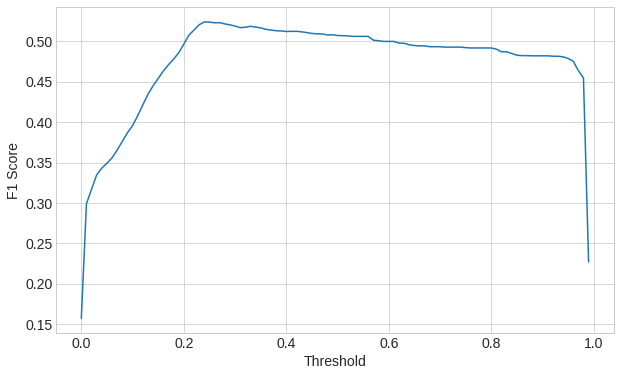

In [ ]:
clf = CatBoostClassifier(n_estimators = 3000,
                       learning_rate = 0.01,
                       rsm = 0.4, ## Analogous to colsample_bytree
                       random_state=2054,
                       )

fit_params = {'verbose': 200, 'early_stopping_rounds': 200}

cb_oofs, cb_preds = run_gradient_boosting(clf, fit_params, train_new, test_new, features)

optimal_thresh = get_optimal_f1_thresh(target, cb_oofs)
print(f'Optimal threhold is {optimal_thresh}')
optimized_f1 = f1_score(target, (cb_oofs > optimal_thresh) * 1)
print(f'Optimized F1 is {optimized_f1}')

In [ ]:
cb_preds_rounded = (cb_preds > optimal_thresh) * 1
download_preds(cb_preds_rounded, file_name = 'HR_Analytics_stacked_cb.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# **Making Our Final Submission**

In [ ]:
?pd.get_dummies

In [ ]:
lgb_preds_rounded = (lgb_preds > optimal_thresh) * 1
download_preds(lgb_preds_rounded, file_name = 'hacklive_5_folds_ensemble.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>